# Data Collection

## FBref Scraper
**Source**: fbref.com match logs  
**Players**: Lewandowski, Yamal, Raphinha, Pedri  
**Data**: Performance stats (goals, assists, xG, passes, tackles, etc.)  
**Method**: Selenium with randomized delays to avoid rate limiting

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import pandas as pd
import json
import time
import random
import os

class SofaScoreScraper:
    def __init__(self):
        # FC Barcelona Players Config
        self.players = {
            'Pedri': {
                'id': '992587',
                'tournaments': {
                    'La Liga': {'tournament_id': '8', 'season_id': '61643'},
                    'Champions League': {'tournament_id': '7', 'season_id': '61644'},
                    'Copa del Rey': {'tournament_id': '329', 'season_id': '66885'},
                    'Supercopa': {'tournament_id': '213', 'season_id': '66001'}
                }
            },
            'Lewandowski': {
                'id': '41789',
                'tournaments': {
                    'La Liga': {'tournament_id': '8', 'season_id': '61643'},
                    'Champions League': {'tournament_id': '7', 'season_id': '61644'},
                    'Copa del Rey': {'tournament_id': '329', 'season_id': '66885'},
                    'Supercopa': {'tournament_id': '213', 'season_id': '66001'}
                }
            },
            'Yamal': {
                'id': '1402912',
                'tournaments': {
                    'La Liga': {'tournament_id': '8', 'season_id': '61643'},
                    'Champions League': {'tournament_id': '7', 'season_id': '61644'},
                    'Copa del Rey': {'tournament_id': '329', 'season_id': '66885'},
                    'Supercopa': {'tournament_id': '213', 'season_id': '66001'}
                }
            },
            'Raphinha': {
                'id': '831005',
                'tournaments': {
                    'La Liga': {'tournament_id': '8', 'season_id': '61643'},
                    'Champions League': {'tournament_id': '7', 'season_id': '61644'},
                    'Copa del Rey': {'tournament_id': '329', 'season_id': '66885'},
                    'Supercopa': {'tournament_id': '213', 'season_id': '66001'}
                }
            }
        }

        opts = Options()
        # opts.add_argument("--headless") # Uncomment for background execution
        opts.add_argument("--disable-gpu")
        opts.add_argument("--window-size=1920,1080")
        opts.add_argument("--log-level=3") 
        self.driver = webdriver.Chrome(options=opts)

    def get_player_ratings(self, player_name, player_id, tournament_id, season_id, tournament_name):
        url = f"https://www.sofascore.com/api/v1/player/{player_id}/unique-tournament/{tournament_id}/season/{season_id}/ratings/overall"
        
        try:
            self.driver.get(url)
            time.sleep(1.5) 

            print(f"   -> Processing {tournament_name}...", end=' ', flush=True)
            
            # API returns raw JSON in a <pre> tag
            json_text = self.driver.find_element("tag name", "pre").text
            data = json.loads(json_text)

            matches = []
            season_ratings = data.get("seasonRatings", [])
            
            for match in season_ratings:
                ts = match.get("startTimestamp")
                date_str = pd.to_datetime(ts, unit='s').strftime('%Y-%m-%d')
                
                matches.append({
                    "Player": player_name,
                    "Competition": tournament_name,
                    "Date": date_str,
                    "Opponent": match.get("opponent", {}).get("name", "Unknown"),
                    "Rating": match.get("rating")
                })

            print(f"Found {len(matches)} matches.")
            return matches

        except Exception as e:
            print(f"Failed. Error: {e}")
            return []

    def scrape_player(self, player_name, player_info):
        print(f"[{player_name}] Starting data collection...")
        all_matches = []
        player_id = player_info['id']

        for tournament_name, t in player_info['tournaments'].items():
            matches = self.get_player_ratings(
                player_name, 
                player_id, 
                t['tournament_id'], 
                t['season_id'], 
                tournament_name
            )
            all_matches.extend(matches)
            # Random delay to avoid rate limiting
            time.sleep(random.uniform(1, 2))

        if all_matches:
            return pd.DataFrame(all_matches)
        return None

    def scrape_all(self):
        all_data = []
        print("Starting SofaScore scraper...")
        
        for name, info in self.players.items():
            df = self.scrape_player(name, info)
            if df is not None:
                all_data.append(df)
            print("-" * 30)
            time.sleep(random.uniform(2, 4))

        self.driver.quit()

        if all_data:
            combined = pd.concat(all_data, ignore_index=True)
            print(f"Finished. Total rows: {len(combined)}")
            return combined
        return None

    def save_data(self, df, filename='sofascore_ratings.csv'):
        if df is None or df.empty:
            print("No data to save.")
            return

        # Remove potential duplicates
        df = df.drop_duplicates(subset=['Player', 'Date', 'Opponent'])
        
        try:
            df.to_csv(filename, index=False)
            print(f"Data saved to: {filename}")
            print(df.head())
        except IOError as e:
            print(f"Could not save file: {e}")

if __name__ == "__main__":
    scraper = SofaScoreScraper()
    data = scraper.scrape_all()
    
    if data is not None:
        scraper.save_data(data)
    else:
        print("Scraper finished with no data.")

Starting SofaScore scraper...
[Pedri] Starting data collection...
   -> Processing La Liga... Found 37 matches.
   -> Processing Champions League... Found 14 matches.
   -> Processing Copa del Rey... Found 6 matches.
   -> Processing Supercopa... Found 2 matches.
------------------------------
[Lewandowski] Starting data collection...
   -> Processing La Liga... Found 34 matches.
   -> Processing Champions League... Found 13 matches.
   -> Processing Copa del Rey... Found 3 matches.
   -> Processing Supercopa... Found 2 matches.
------------------------------
[Yamal] Starting data collection...
   -> Processing La Liga... Found 35 matches.
   -> Processing Champions League... Found 13 matches.
   -> Processing Copa del Rey... Found 5 matches.
   -> Processing Supercopa... Found 2 matches.
------------------------------
[Raphinha] Starting data collection...
   -> Processing La Liga... Found 36 matches.
   -> Processing Champions League... Found 14 matches.
   -> Processing Copa del Rey

## SofaScore Scraper
**Source**: sofascore.com API  
**Players**: Same 4 players  
**Data**: Match ratings  
**Competitions**: La Liga, Champions League, Copa del Rey, Supercopa  
**Method**: Chrome driver accessing JSON endpoints

In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
import random

def get_chrome_driver(headless=True):
    """Configures and returns a Chrome driver instance."""
    opts = Options()
    if headless:
        opts.add_argument('--headless')
        opts.add_argument('--disable-gpu')
    
    opts.add_argument('--no-sandbox')
    opts.add_argument('--disable-dev-shm-usage')
    opts.add_argument('--disable-blink-features=AutomationControlled')
    opts.add_experimental_option("excludeSwitches", ["enable-automation"])
    opts.add_experimental_option('useAutomationExtension', False)
    opts.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36')
    
    service = Service(ChromeDriverManager().install())
    return webdriver.Chrome(service=service, options=opts)

class FBrefScraper:
    def __init__(self):
        self.players = {
            'Lewandowski': 'https://fbref.com/en/players/8d78e732/matchlogs/2024-2025/summary/Robert-Lewandowski-Match-Logs',
            'Yamal': 'https://fbref.com/en/players/82ec26c1/matchlogs/2024-2025/Lamine-Yamal-Match-Logs',
            'Raphinha': 'https://fbref.com/en/players/3423f250/matchlogs/2024-2025/Raphinha-Match-Logs',
            'Pedri': 'https://fbref.com/en/players/0d9b2d31/matchlogs/2024-2025/Pedri-Match-Logs'
        }
    
    def scrape_player(self, player_name, url):
        print(f"[{player_name}] Starting scrape...")
        
        driver = None
        try:
            driver = get_chrome_driver(headless=True)
            driver.get(url)
            
            # Random wait for page elements
            wait_time = random.uniform(12, 18)
            print(f"Waiting {wait_time:.1f}s for tables...")
            time.sleep(wait_time)
            
            tables = driver.find_elements(By.CSS_SELECTOR, "table.stats_table")
            matches = []

            for table in tables:
                rows = table.find_elements(By.CSS_SELECTOR, "tbody tr")
                for row in rows:
                    try:
                        # Skip header rows or empty dates
                        th = row.find_element(By.TAG_NAME, "th")
                        date = th.text.strip()
                        if not date:
                            continue
                    except:
                        continue

                    match_data = {'Player': player_name, 'Date': date}
                    cells = row.find_elements(By.TAG_NAME, "td")
                    
                    for cell in cells:
                        stat_name = cell.get_attribute('data-stat')
                        value = cell.text.strip()
                        if stat_name:
                            match_data[stat_name] = value

                    # Check validity
                    if 'team' in match_data and match_data['team']:
                        matches.append(match_data)
            
            df = pd.DataFrame(matches)

            # Filter for Barcelona games only
            if not df.empty and 'team' in df.columns:
                df = df[df['team'].str.contains('Barcelona', case=False, na=False)].copy()

            print(f"Matches found: {len(df)}")
            return df
            
        except Exception as e:
            print(f"Error scraping {player_name}: {e}")
            return None
            
        finally:
            if driver:
                driver.quit()
    
    def scrape_all(self):
        all_data = []
        
        for player_name, url in self.players.items():
            df = self.scrape_player(player_name, url)
            if df is not None and len(df) > 0:
                all_data.append(df)
            
            # Pause between players to be polite to the server
            wait_time = random.uniform(10, 15)
            print(f"Sleeping {wait_time:.1f}s...")
            time.sleep(wait_time)
        
        if all_data:
            combined = pd.concat(all_data, ignore_index=True)
            print(f"Scrape complete. Total rows: {len(combined)}")
            return combined
        return None
    
    def save_data(self, df, filename='fbref_barcelona_only.csv'):
        if df is None or df.empty:
            print("No data to save.")
            return

        # Basic column cleaning
        rename_map = { 
            'date':'Date', 'comp':'Competition', 'team':'Team', 
            'opponent':'Opponent', 'game_started':'Started', 
            'minutes':'Min', 'goals':'Gls', 'assists':'Ast' 
        }
        df = df.rename(columns=rename_map)

        # Double check filtering
        if 'Team' in df.columns:
            df = df[df['Team'].str.contains('Barcelona', case=False, na=False)]

        try:
            df.to_csv(filename, index=False)
            print(f"File saved: {filename}")
            print(df.head())
        except IOError as e:
            print(f"Save failed: {e}")

def main():
    print("Starting FBref Scraper (Barcelona Filter)...")
    
    scraper = FBrefScraper()
    data = scraper.scrape_all()
    
    if data is not None:
        scraper.save_data(data)
    else:
        print("Finished with no data.")

if __name__ == "__main__":
    main()

Starting FBref Scraper (Barcelona Filter)...
[Lewandowski] Starting scrape...
Waiting 13.3s for tables...
Matches found: 52
Sleeping 13.1s...
[Yamal] Starting scrape...
Waiting 13.8s for tables...
Matches found: 55
Sleeping 14.2s...
[Raphinha] Starting scrape...
Waiting 15.2s for tables...
Matches found: 57
Sleeping 11.0s...
[Pedri] Starting scrape...
Waiting 13.7s for tables...
Matches found: 59
Sleeping 10.4s...
Scrape complete. Total rows: 223
File saved: fbref_barcelona_only.csv
        Player        Date dayofweek Competition        round venue result  \
0  Lewandowski  2024-08-17       Sat     La Liga  Matchweek 1  Away  W 2–1   
1  Lewandowski  2024-08-24       Sat     La Liga  Matchweek 2  Home  W 2–1   
2  Lewandowski  2024-08-27       Tue     La Liga  Matchweek 3  Away  W 2–1   
3  Lewandowski  2024-08-31       Sat     La Liga  Matchweek 4  Home  W 7–0   
4  Lewandowski  2024-09-15       Sun     La Liga  Matchweek 5  Away  W 4–1   

        Team        Opponent Started  ... g

## Merge Script
Combines FBref stats with SofaScore ratings on `Player` + `Date`.  
**Output**: `fbref_sofascore_merged_by_date_only.csv`

In [7]:
import pandas as pd

# Load datasets
fbref_df = pd.read_csv("fbref_barcelona_only.csv")
sofascore_df = pd.read_csv("sofascore_ratings.csv")

# Standardize dates
fbref_df['Date'] = pd.to_datetime(fbref_df['Date'])
sofascore_df['Date'] = pd.to_datetime(sofascore_df['Date'])

# Merge on Player + Date only
merged_df = pd.merge(
    fbref_df,
    sofascore_df[['Player', 'Date', 'Rating']],  # only keep relevant columns
    how='left',
    on=['Player', 'Date']
)

# Sort by player and date
merged_df = merged_df.sort_values(['Player', 'Date']).reset_index(drop=True)

# Save
merged_df.to_csv("fbref_sofascore_merged_by_date_only.csv", index=False)

print(f"Merged dataset saved. Total rows: {len(merged_df)}")
print(merged_df.head(10))


Merged dataset saved. Total rows: 223
        Player       Date dayofweek   Competition         round venue result  \
0  Lewandowski 2024-08-17       Sat       La Liga   Matchweek 1  Away  W 2–1   
1  Lewandowski 2024-08-24       Sat       La Liga   Matchweek 2  Home  W 2–1   
2  Lewandowski 2024-08-27       Tue       La Liga   Matchweek 3  Away  W 2–1   
3  Lewandowski 2024-08-31       Sat       La Liga   Matchweek 4  Home  W 7–0   
4  Lewandowski 2024-09-15       Sun       La Liga   Matchweek 5  Away  W 4–1   
5  Lewandowski 2024-09-19       Thu  Champions Lg  League phase  Away  L 1–2   
6  Lewandowski 2024-09-22       Sun       La Liga   Matchweek 6  Away  W 5–1   
7  Lewandowski 2024-09-25       Wed       La Liga   Matchweek 7  Home  W 1–0   
8  Lewandowski 2024-09-28       Sat       La Liga   Matchweek 8  Away  L 2–4   
9  Lewandowski 2024-10-01       Tue  Champions Lg  League phase  Home  W 5–0   

           Team        Opponent Started  ... passes_completed  passes  \
0     Ba

# Barcelona Player Performance - EDA

***Dataset***

223 matches, 4 players, 2024-25 season

***Analysis***

- Data quality: Missing values, descriptive stats, player summaries
- Performance by result: Ratings across W/D/L
- Correlations: Attacking vs creative metrics impact on ratings
- Outliers: IQR-based detection of exceptional performances

***Metrics***

- Attacking: Goals, xG, npxG, shots, xA
- Creative: SCA, GCA, progressive passes/carries, take-ons
- Discipline: Yellow/red cards

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
import warnings
import os

warnings.filterwarnings('ignore')

class BarcelonaStats:
    def __init__(self, data_file):
        if not os.path.exists(data_file):
            raise FileNotFoundError(f"File not found: {data_file}")
            
        self.df = pd.read_csv(data_file)
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        
        # Metric definitions (needed for correlation analysis)
        self.attacking_metrics = ['Gls', 'Ast', 'shots', 'shots_on_target', 'xg', 'npxg', 'xg_assist']
        self.creative_metrics = ['sca', 'gca', 'progressive_passes', 'progressive_carries', 
                                'passes_completed', 'passes_pct', 'take_ons', 'take_ons_won']
        self.discipline_metrics = ['cards_yellow', 'cards_red']
        
        print(f"Loaded {len(self.df)} rows. Date range: {self.df['Date'].min().date()} to {self.df['Date'].max().date()}")
    
    def get_dataframe(self):
        return self.df

    def run_all_stats(self):
        self.data_overview()
        self.player_summary()
        self.match_result_analysis()
        self.correlation_analysis()
        self.outlier_detection()

    def data_overview(self):
        print("\n" + "="*50)
        print(" DATA OVERVIEW ")
        print("="*50)
        print(f"Shape: {self.df.shape}")
        print(f"Columns: {list(self.df.columns)}")
        
        missing = self.df.isnull().sum()
        if missing.sum() > 0:
            print("\nMissing Values:")
            print(missing[missing > 0])
        
        print("\nDescriptive Statistics:")
        cols = ['Rating', 'Min', 'Gls', 'Ast', 'xg', 'sca']
        print(self.df[[c for c in cols if c in self.df.columns]].describe())
    
    def player_summary(self):
        print("\n" + "="*50)
        print(" PLAYER SUMMARIES ")
        print("="*50)
        for player in self.df['Player'].unique():
            player_data = self.df[self.df['Player'] == player]
            starts = (player_data['Started'] == 'Y').sum()
            
            print(f"[{player}]")
            print(f"  Matches: {len(player_data)} (Starts: {starts})")
            print(f"  Rating: {player_data['Rating'].mean():.2f} +/- {player_data['Rating'].std():.2f}")
            print(f"  G/A: {player_data['Gls'].sum()} / {player_data['Ast'].sum()}")
            print(f"  Avg Min: {player_data['Min'].mean():.1f}")
    
    def match_result_analysis(self):
        print("\n" + "="*50)
        print(" PERFORMANCE BY RESULT ")
        print("="*50)
        if 'result' in self.df.columns:
            print(self.df['result'].value_counts())
            
            print("\nAverage Rating by Result:")
            for result_type in ['W', 'D', 'L']:
                mask = self.df['result'].str.contains(result_type, na=False)
                if mask.sum() > 0:
                    avg = self.df.loc[mask, 'Rating'].mean()
                    std = self.df.loc[mask, 'Rating'].std()
                    print(f"  {result_type}: {avg:.2f} (std: {std:.2f}) n={mask.sum()}")
    
    def correlation_analysis(self):
        print("\n" + "="*50)
        print(" CORRELATION ANALYSIS ")
        print("="*50)
        all_metrics = (self.attacking_metrics + self.creative_metrics + self.discipline_metrics)
        
        print("Metric correlations with Rating (Pearson | Spearman):")
        for metric in all_metrics:
            if metric in self.df.columns:
                mask = self.df[metric].notna() & self.df['Rating'].notna()
                if mask.sum() > 10:
                    corr_p, _ = stats.pearsonr(self.df.loc[mask, metric], self.df.loc[mask, 'Rating'])
                    corr_s, _ = spearmanr(self.df.loc[mask, metric], self.df.loc[mask, 'Rating'])
                    print(f"  {metric:25s}: {corr_p:6.3f} | {corr_s:6.3f}")
    
    def outlier_detection(self):
        print("\n" + "="*50)
        print(" OUTLIER DETECTION (IQR) ")
        print("="*50)
        metrics_to_check = ['Rating', 'Gls', 'Ast', 'xg', 'sca']
        
        for metric in metrics_to_check:
            if metric in self.df.columns:
                data = self.df[metric].dropna()
                Q1 = data.quantile(0.25)
                Q3 = data.quantile(0.75)
                IQR = Q3 - Q1
                bounds = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
                
                outliers = self.df[(self.df[metric] < bounds[0]) | (self.df[metric] > bounds[1])]
                
                print(f"[{metric}] Bounds: {bounds[0]:.2f} - {bounds[1]:.2f}. Outliers found: {len(outliers)}")
                if not outliers.empty:
                    for _, row in outliers[['Player', 'Date', 'Opponent', metric]].head(3).iterrows():
                        print(f"    {row['Player']} vs {row['Opponent']}: {row[metric]}")

# --- EXECUTION ---
data_file = 'fbref_sofascore_merged_by_date_only.csv'
stats_eda = BarcelonaStats(data_file)
stats_eda.run_all_stats()

Loaded 223 rows. Date range: 2024-08-17 to 2025-05-25

 DATA OVERVIEW 
Shape: (223, 39)
Columns: ['Player', 'Date', 'dayofweek', 'Competition', 'round', 'venue', 'result', 'Team', 'Opponent', 'Started', 'position', 'Min', 'Gls', 'Ast', 'pens_made', 'pens_att', 'shots', 'shots_on_target', 'cards_yellow', 'cards_red', 'touches', 'tackles', 'interceptions', 'blocks', 'xg', 'npxg', 'xg_assist', 'sca', 'gca', 'passes_completed', 'passes', 'passes_pct', 'progressive_passes', 'carries', 'progressive_carries', 'take_ons', 'take_ons_won', 'match_report', 'Rating']

Missing Values:
position                2
touches                27
tackles                27
blocks                 27
xg                     27
npxg                   27
xg_assist              27
sca                    27
gca                    27
passes_completed       27
passes                 27
passes_pct             27
progressive_passes     27
carries                27
progressive_carries    27
take_ons               27
take_

## Visualizations
15 visualizations: distributions (1), heatmap (1), violin plots (1), scatter plots per player (8), discipline (1), comparisons (1), impact profiles (1), time series (1)

Generating visualizations...


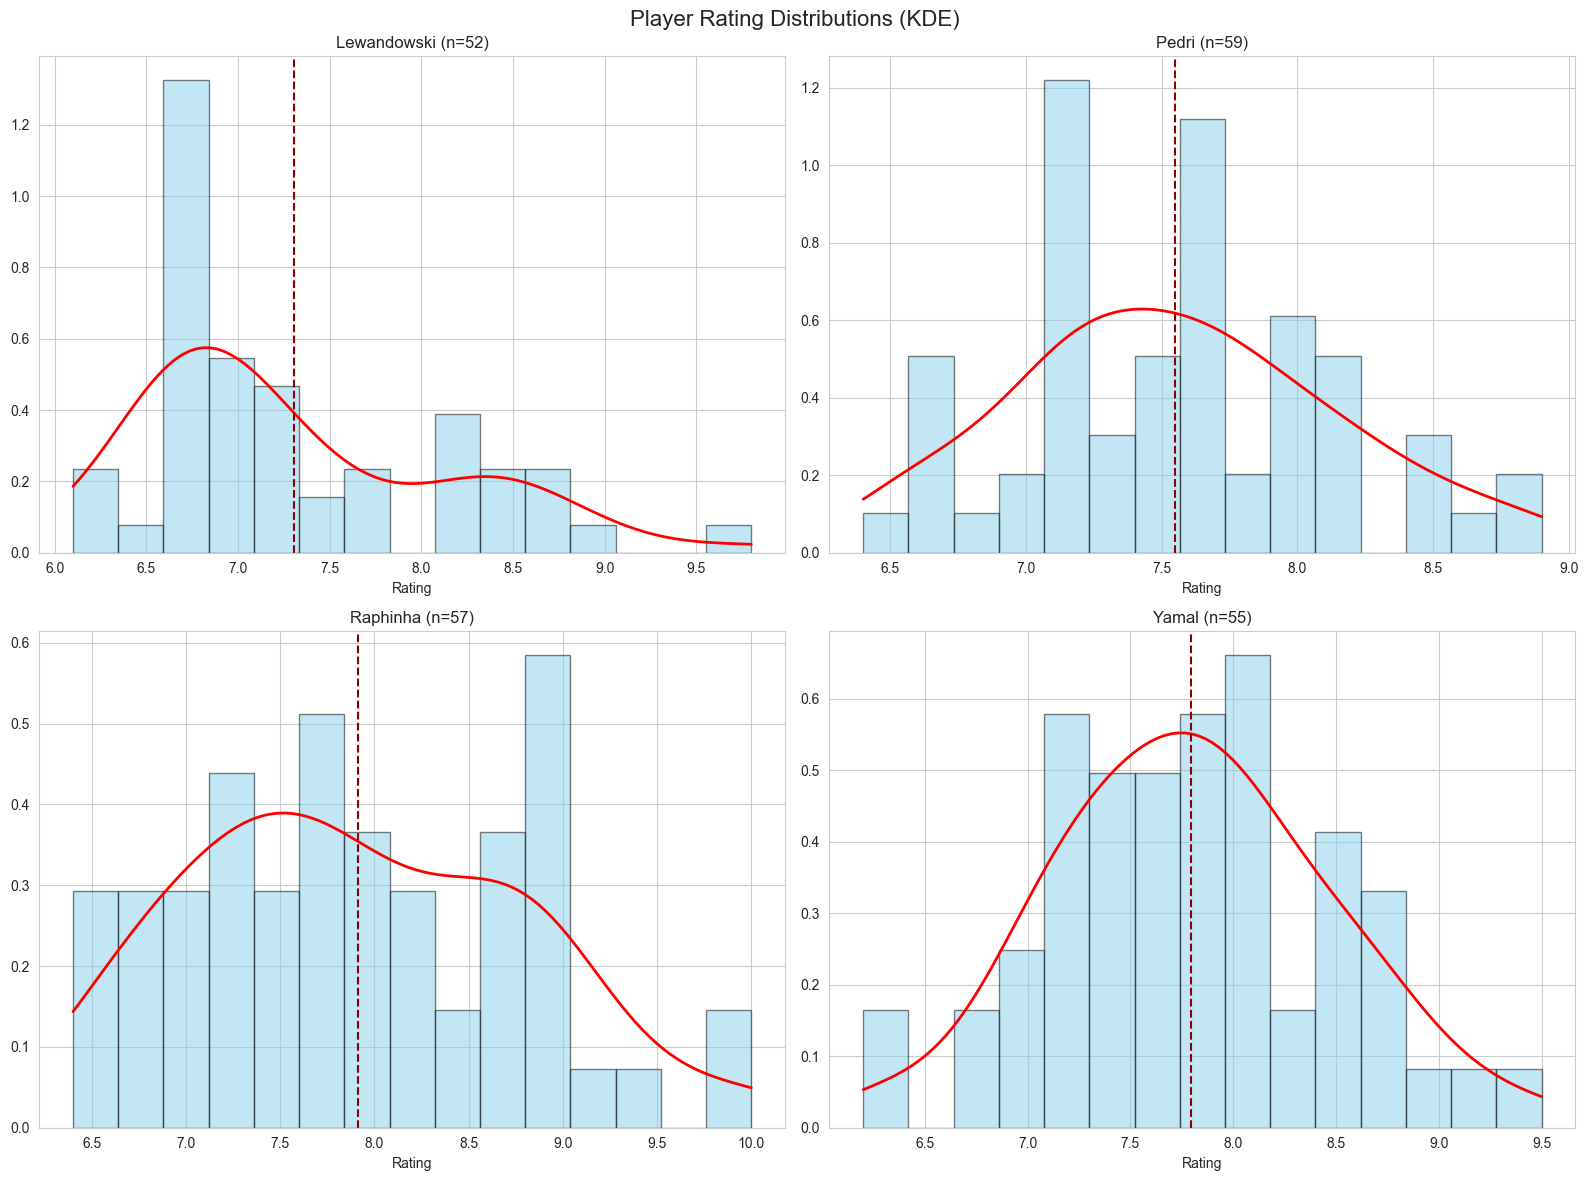

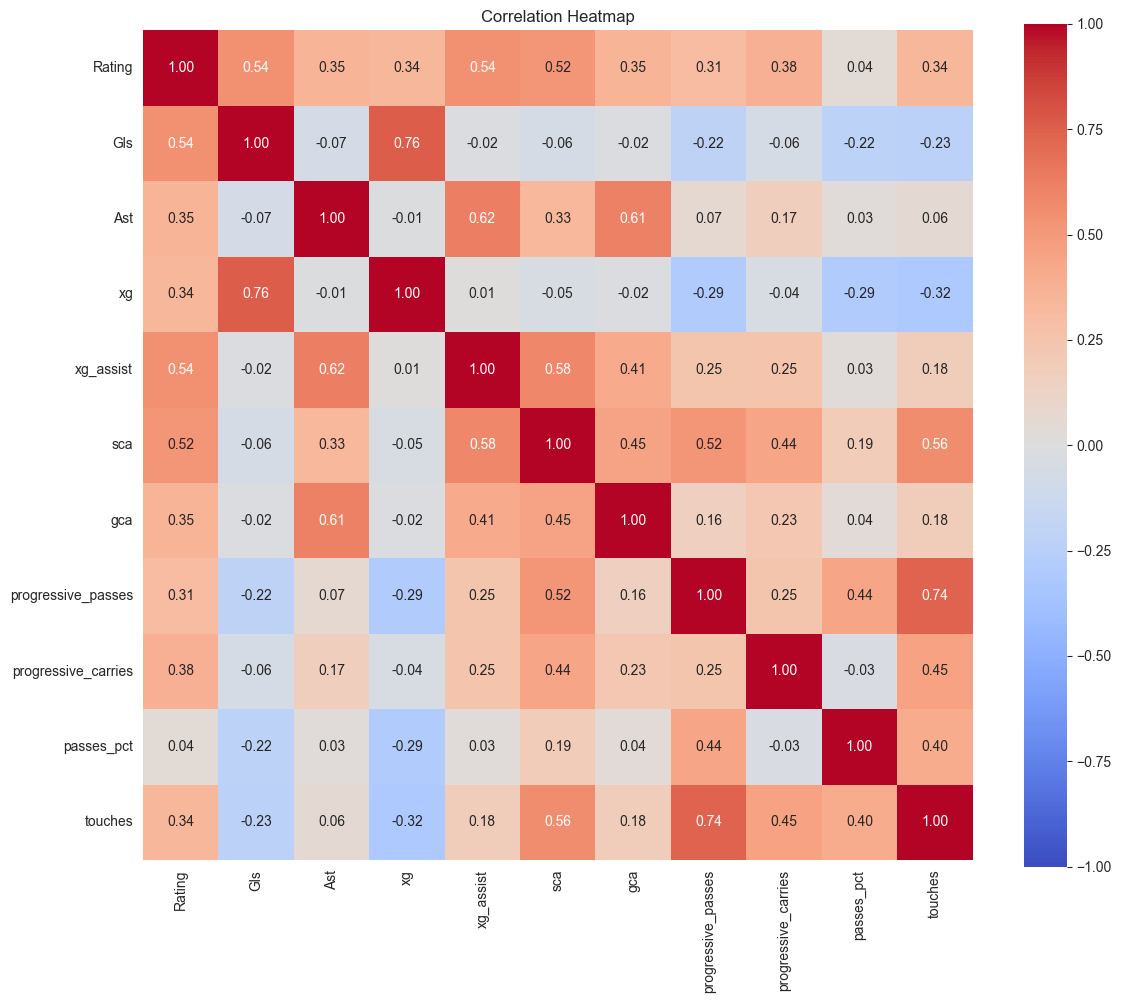

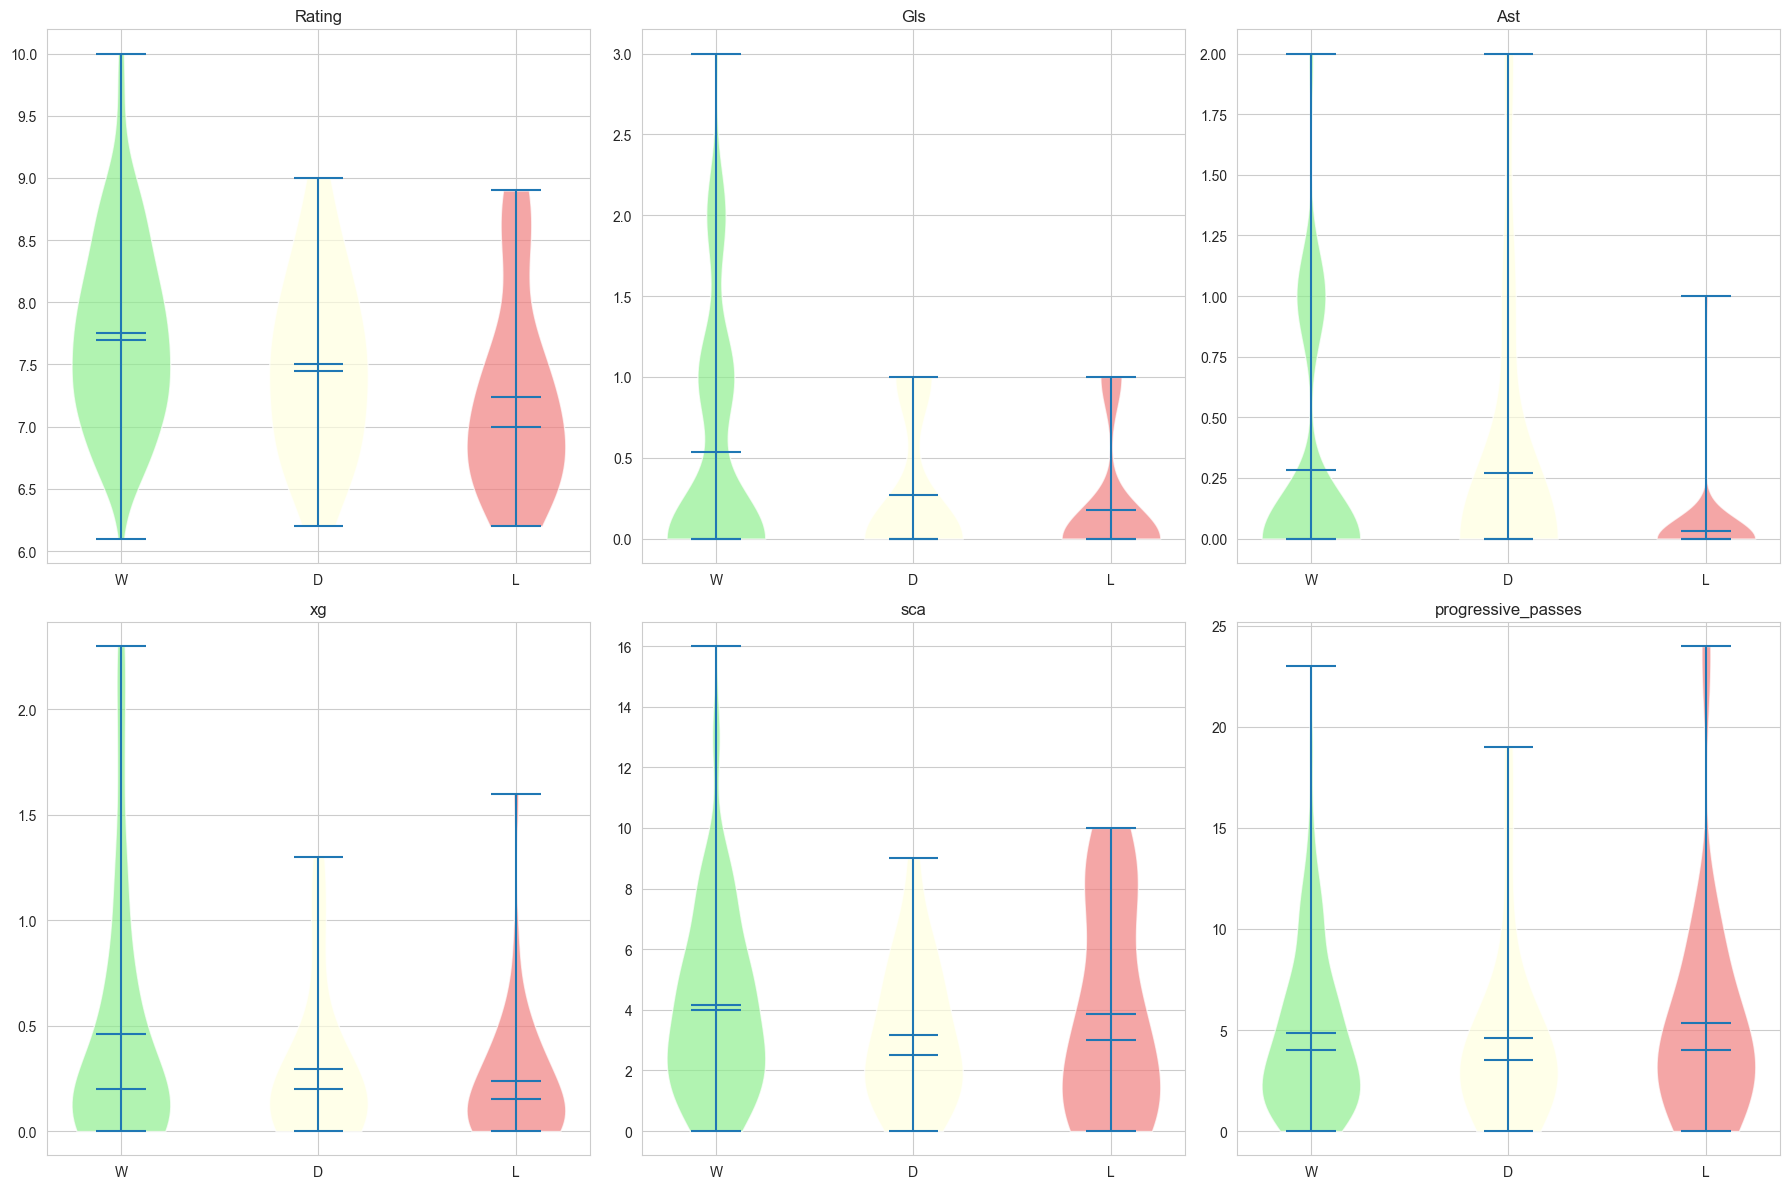

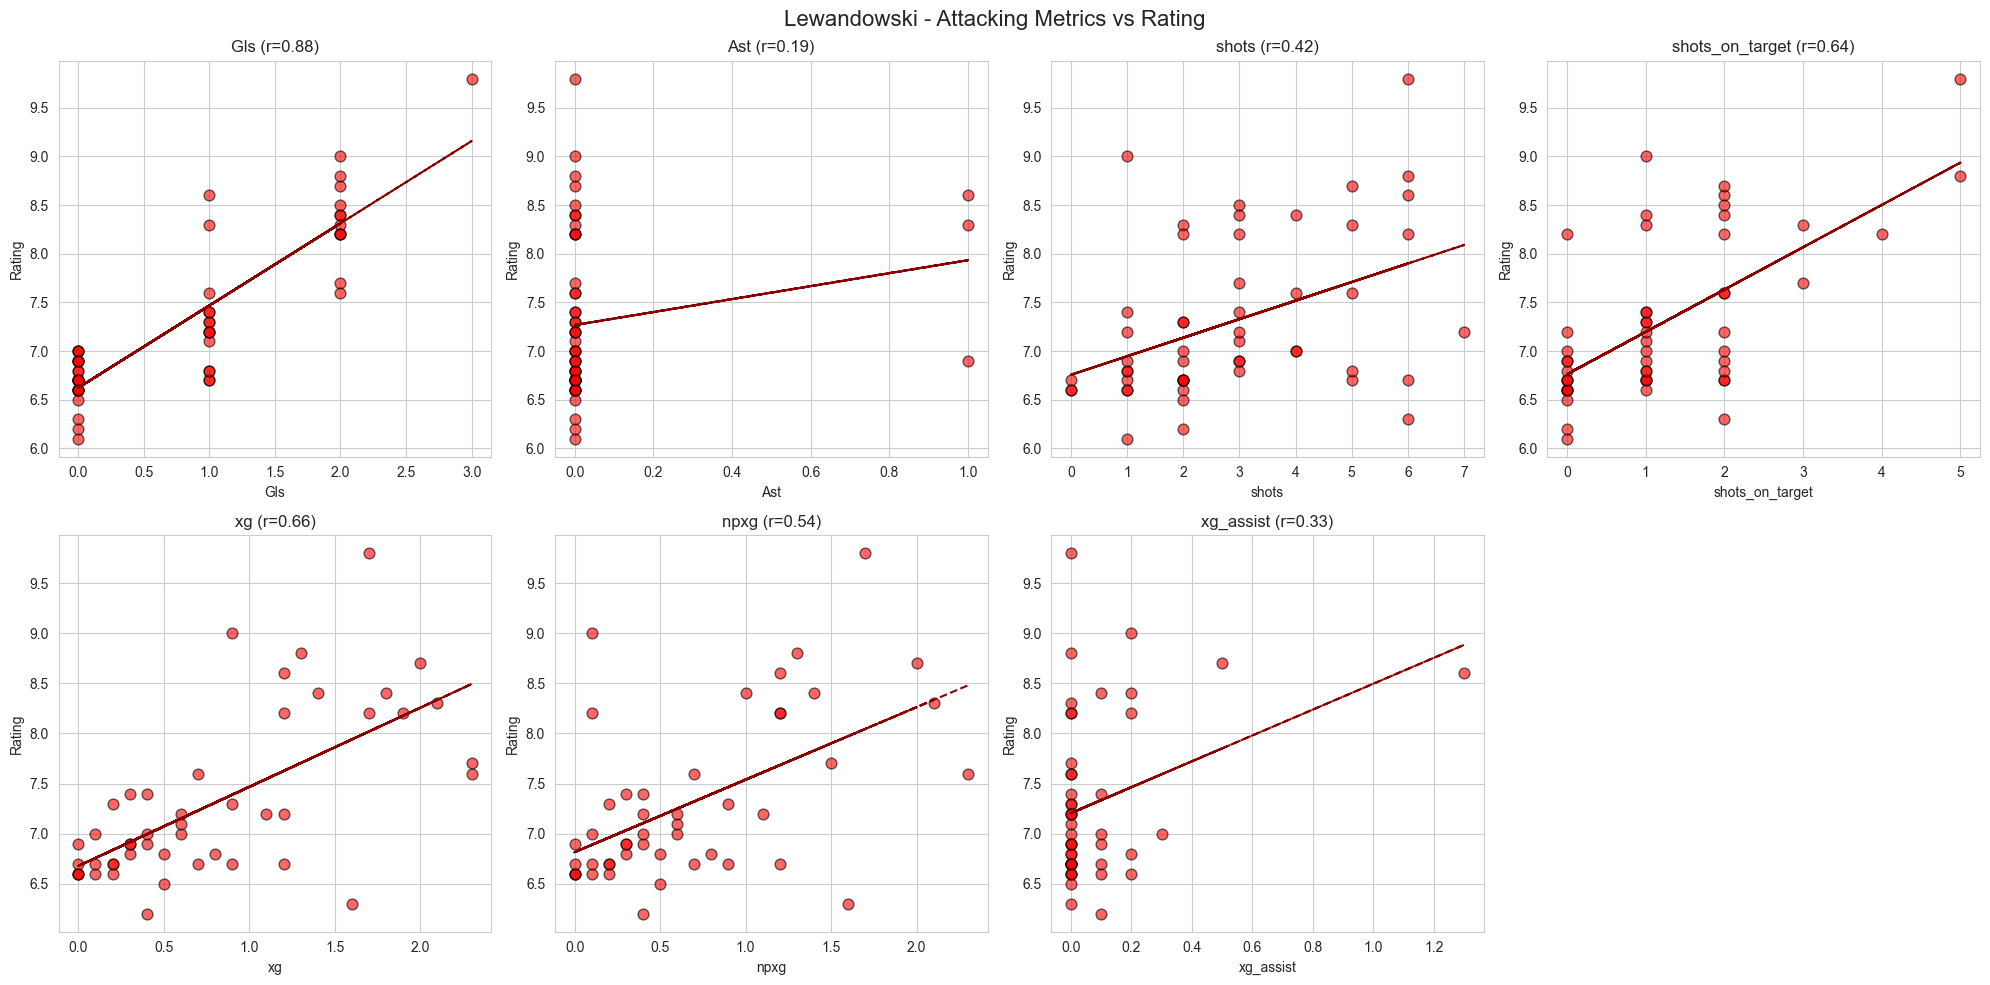

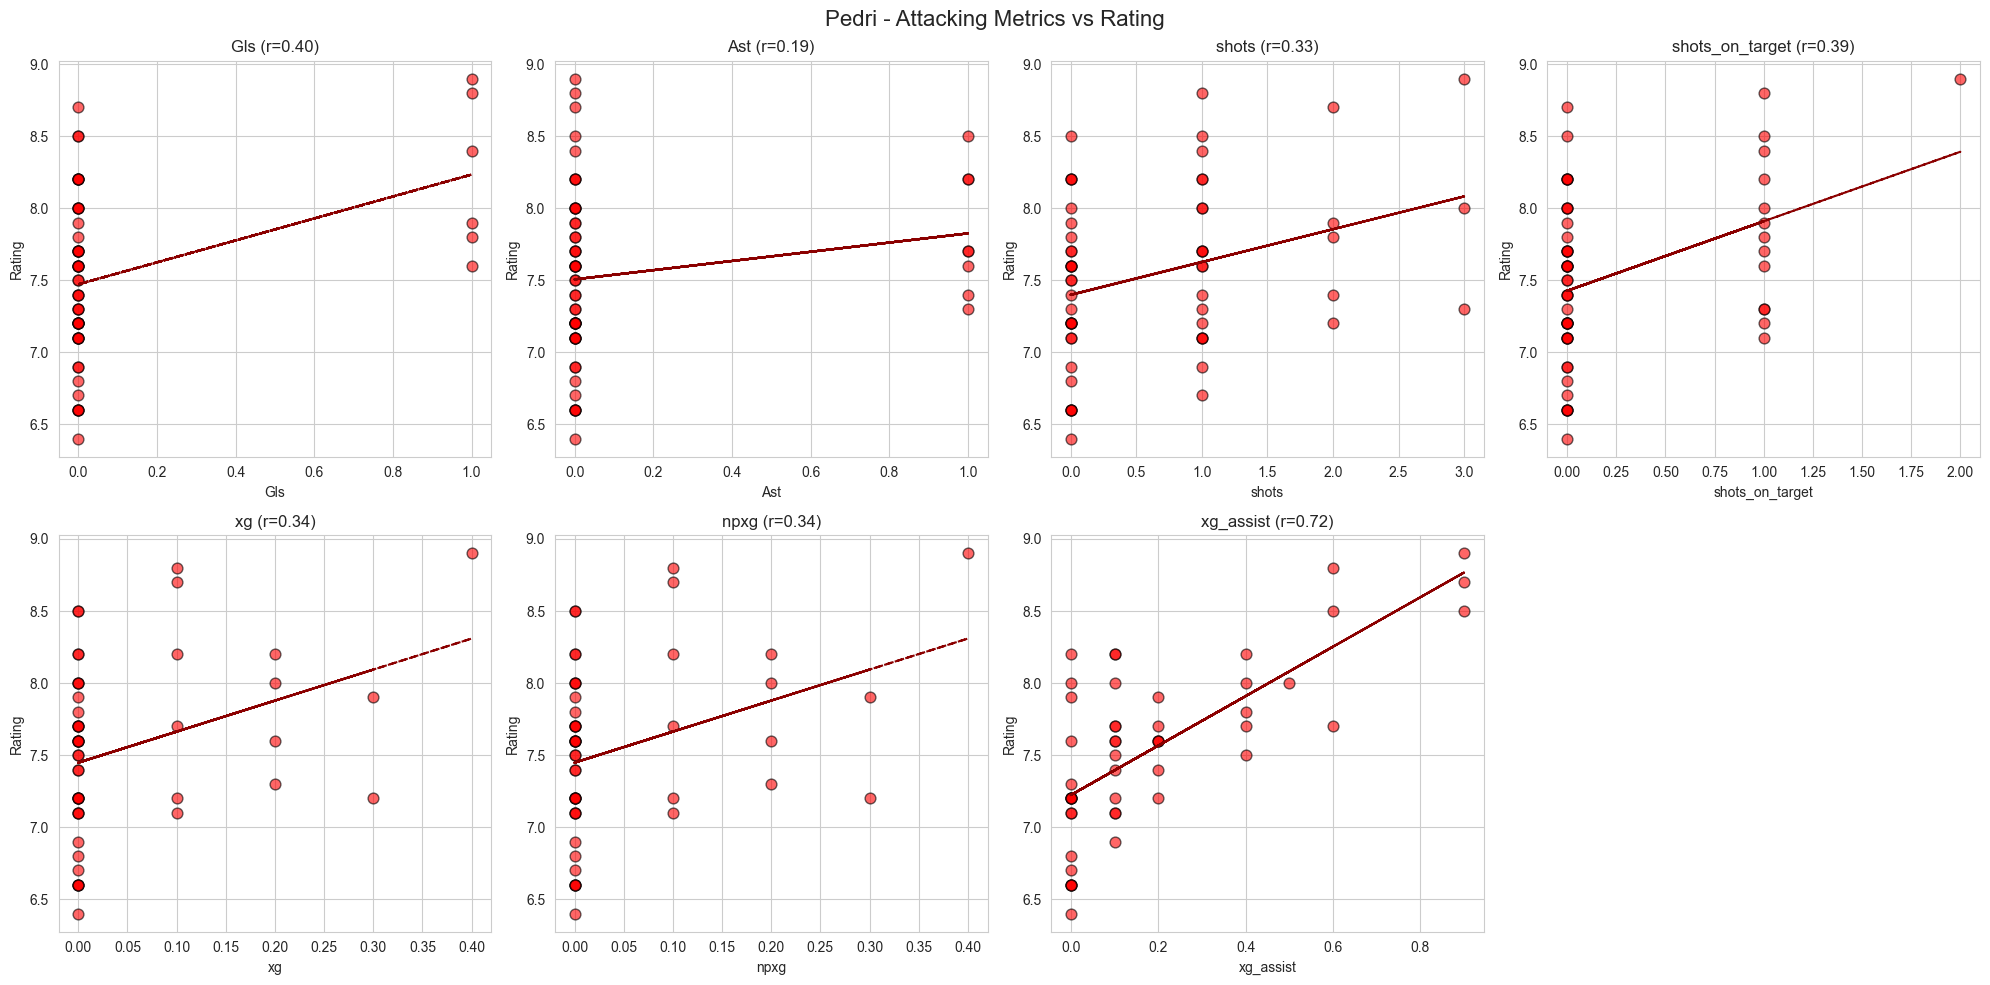

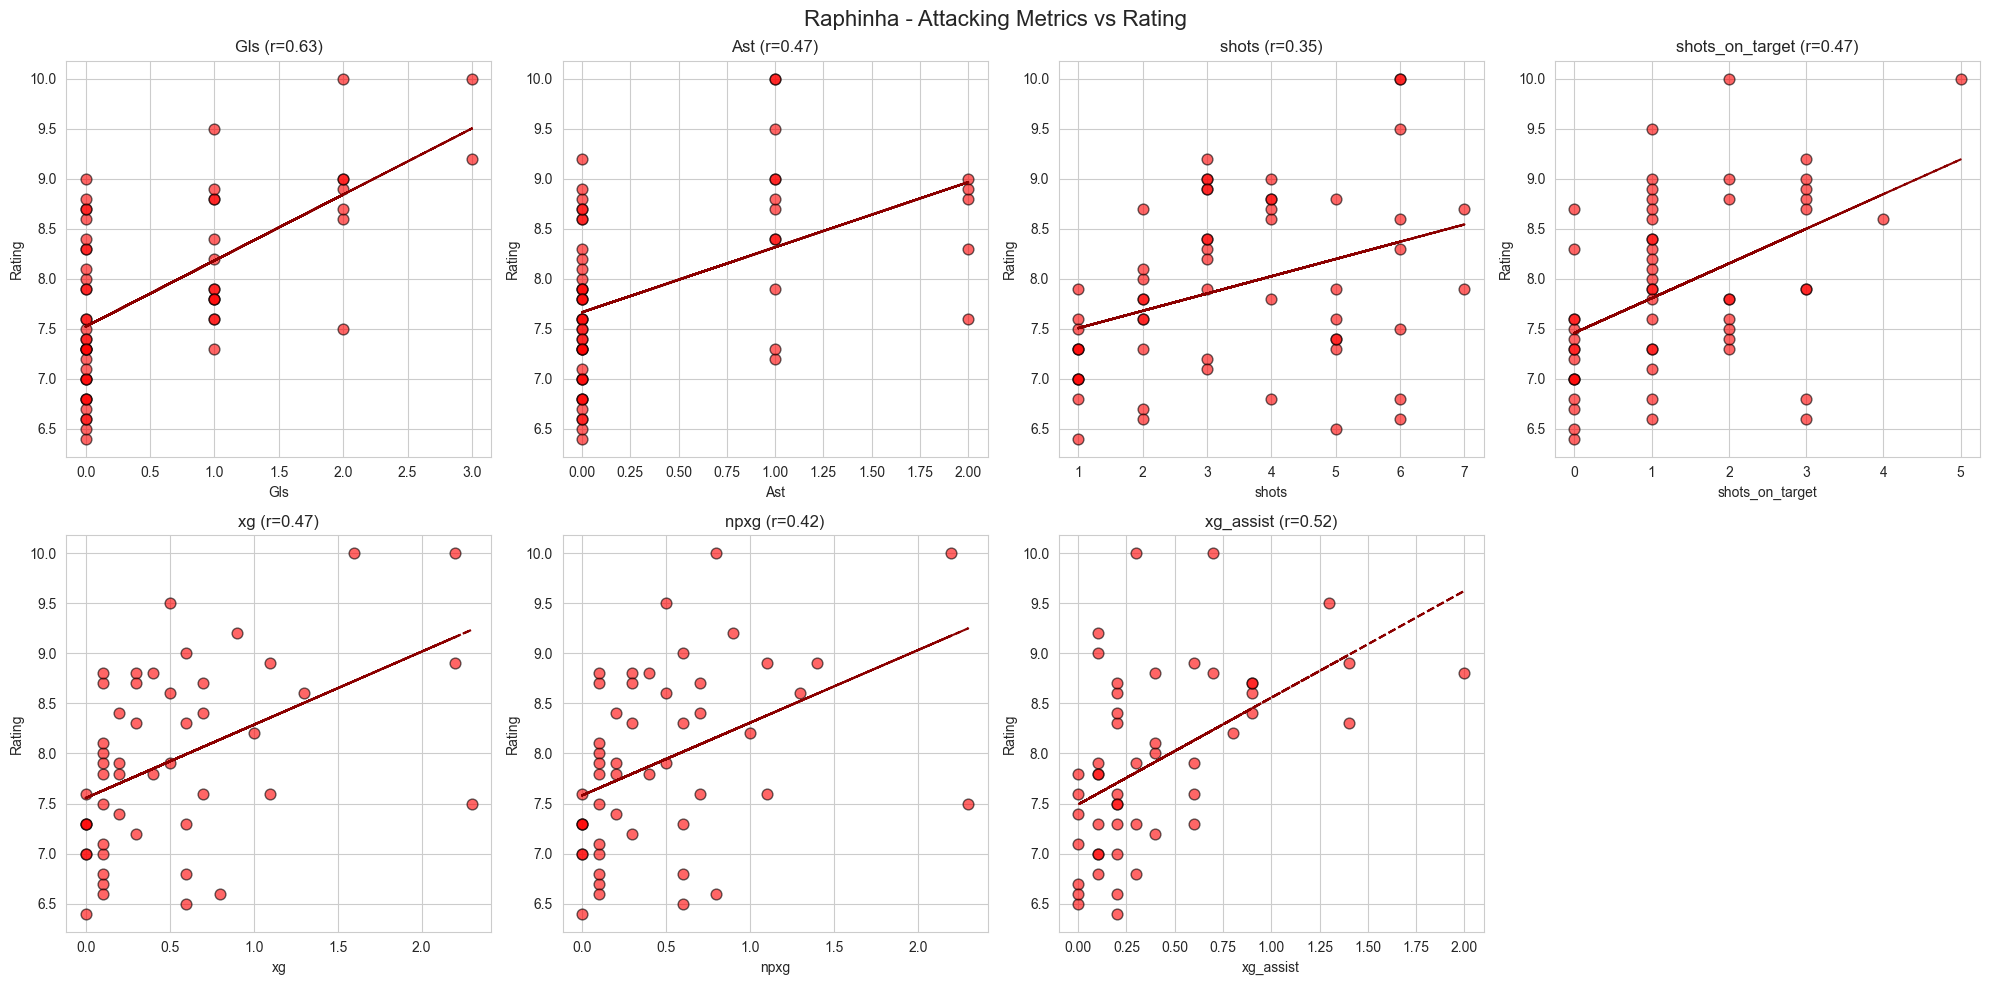

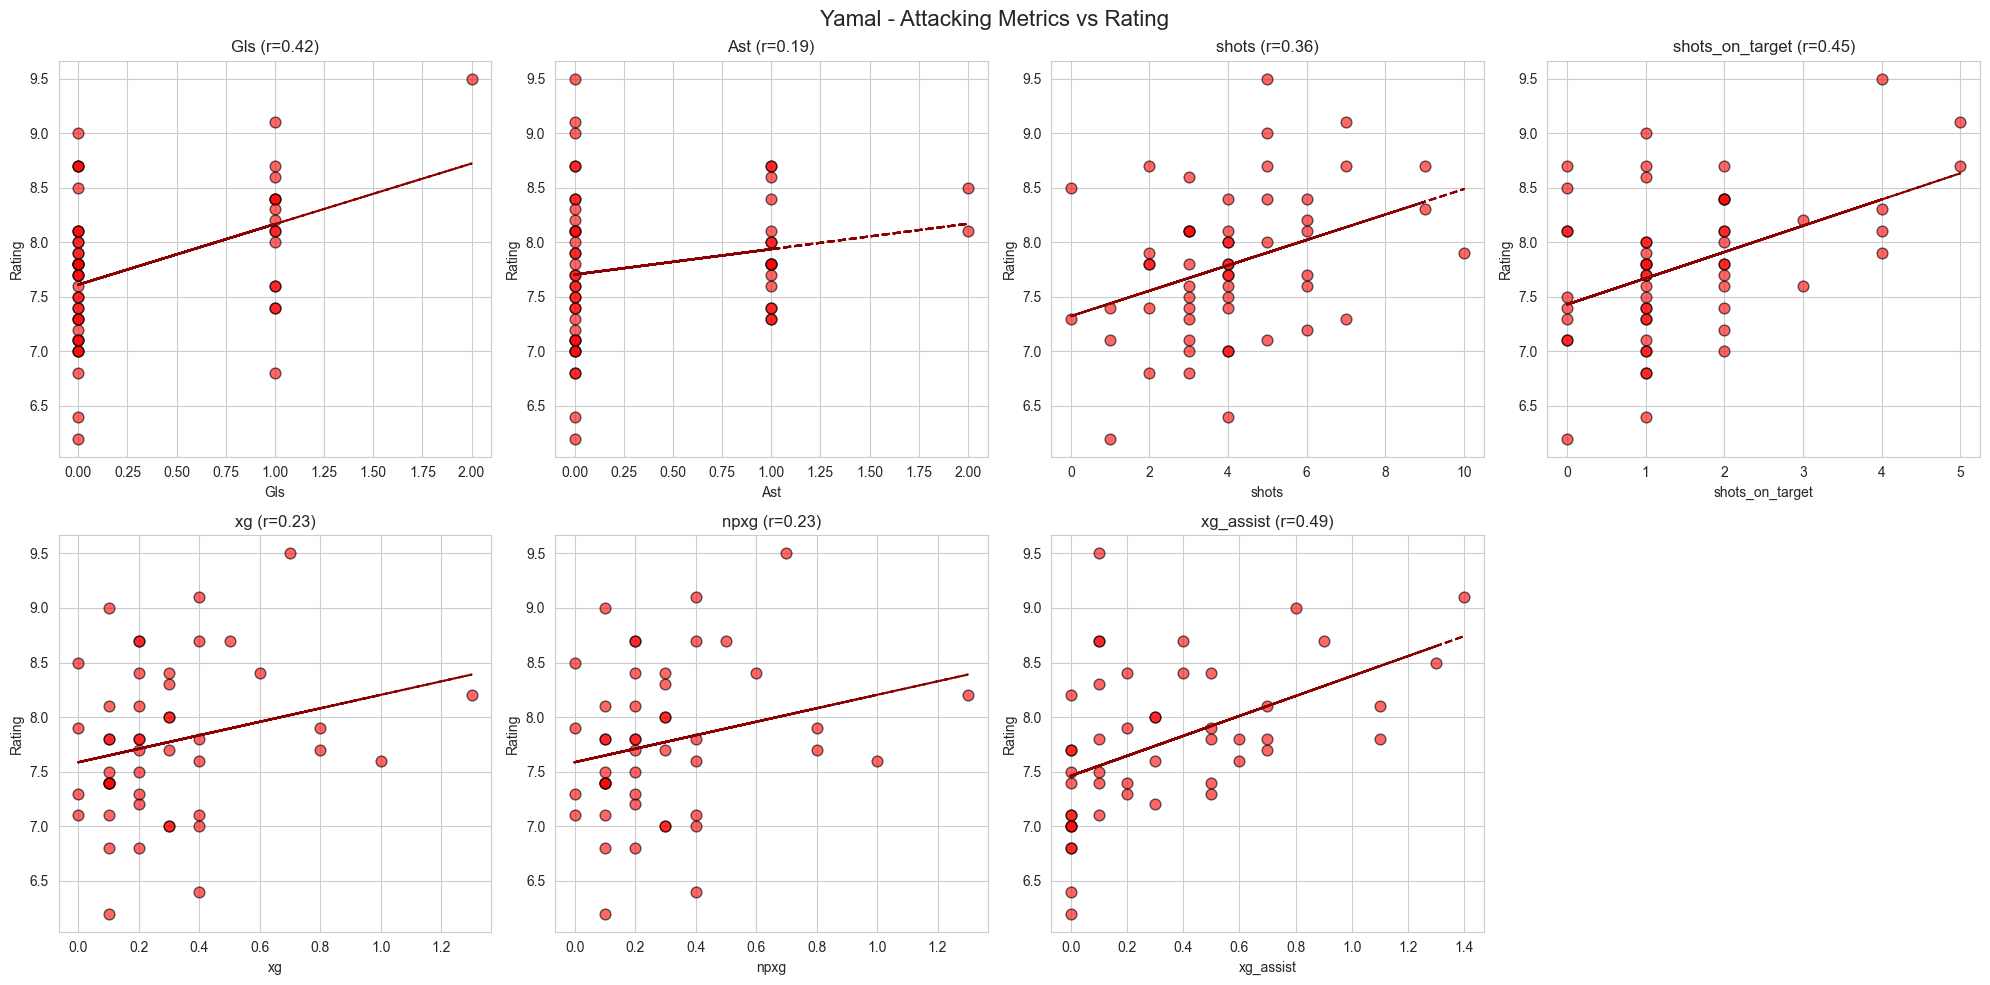

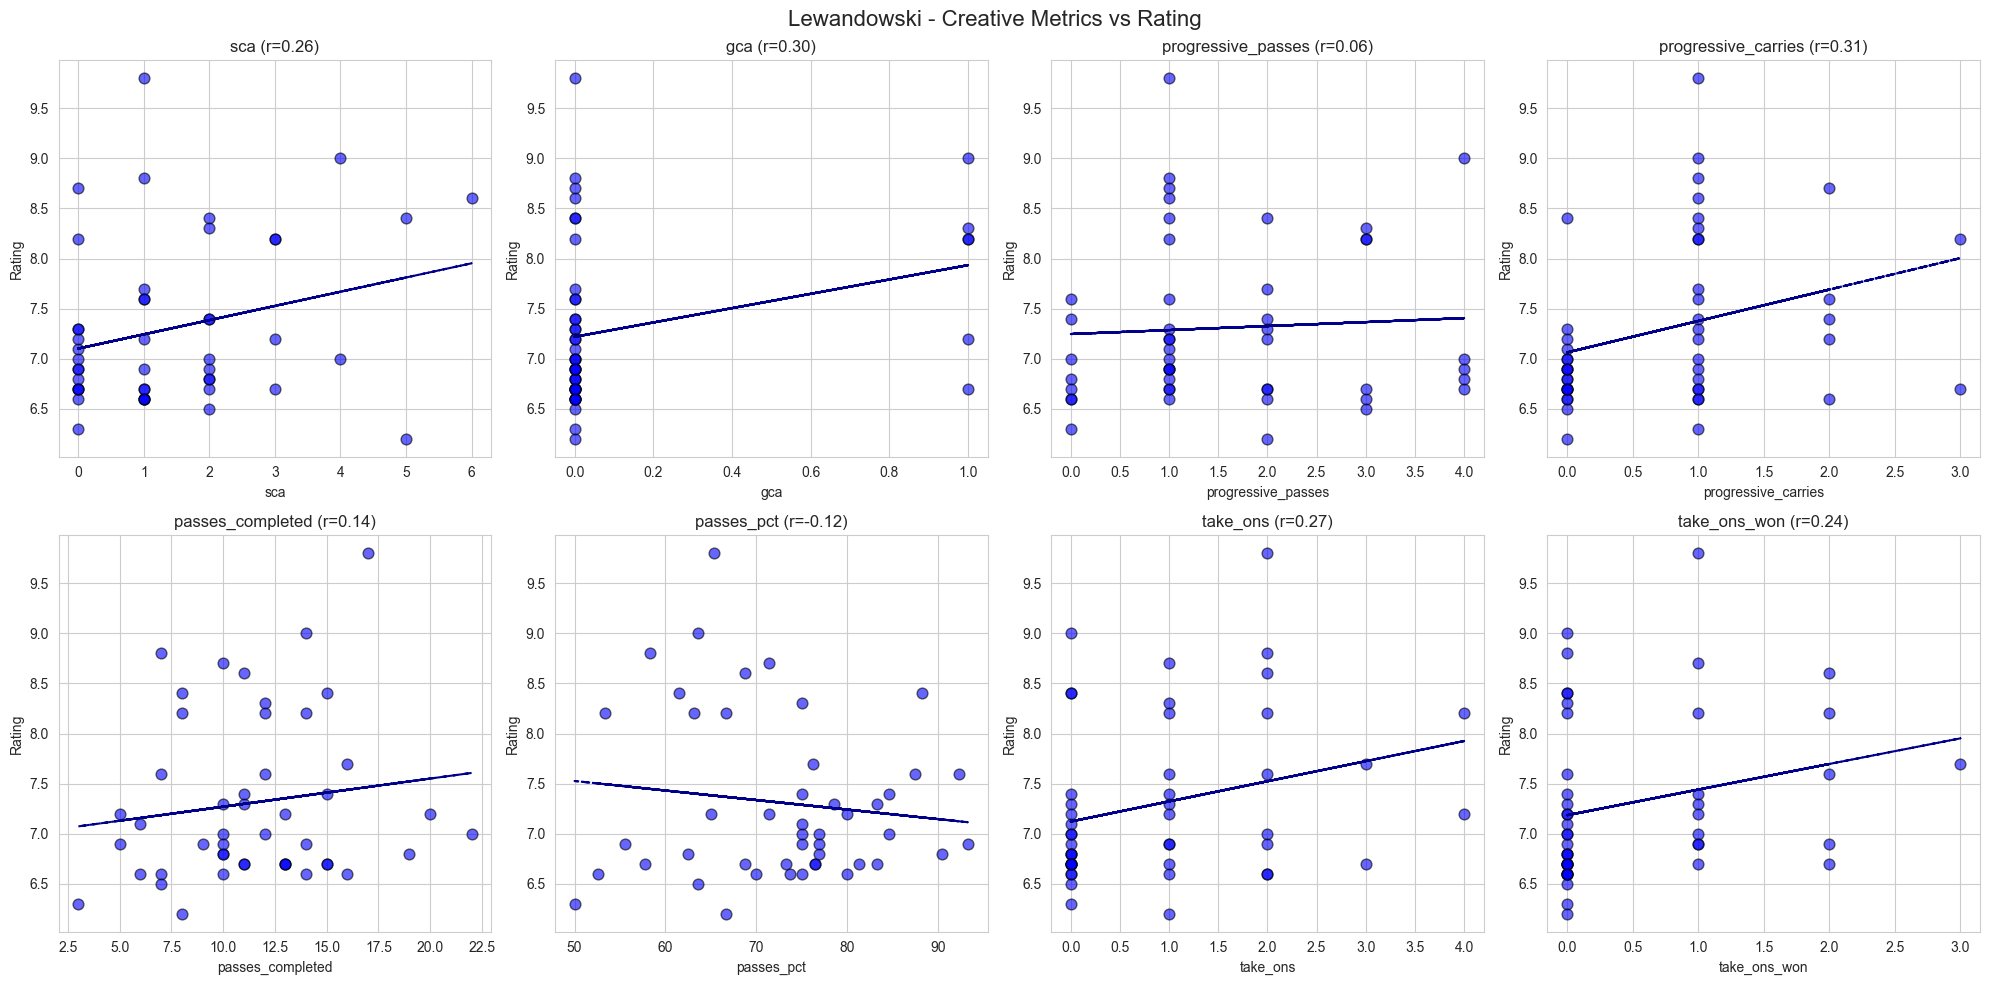

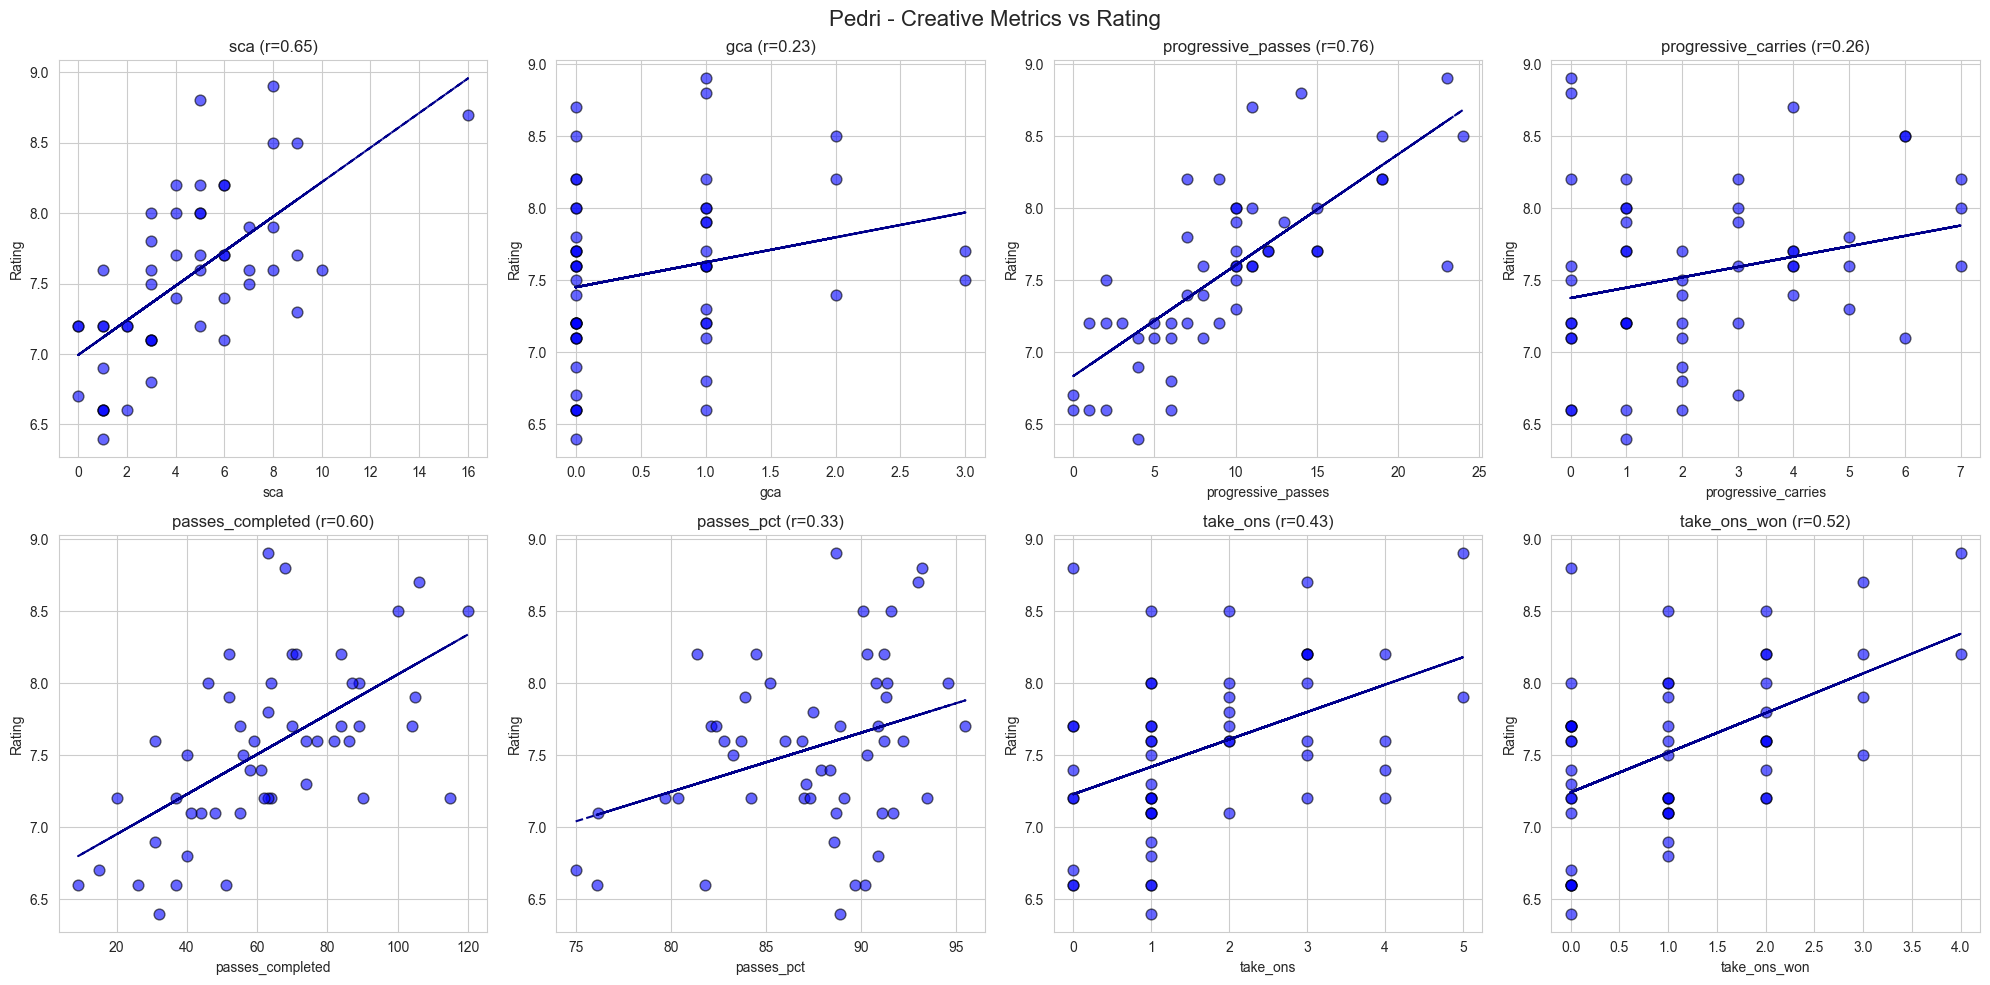

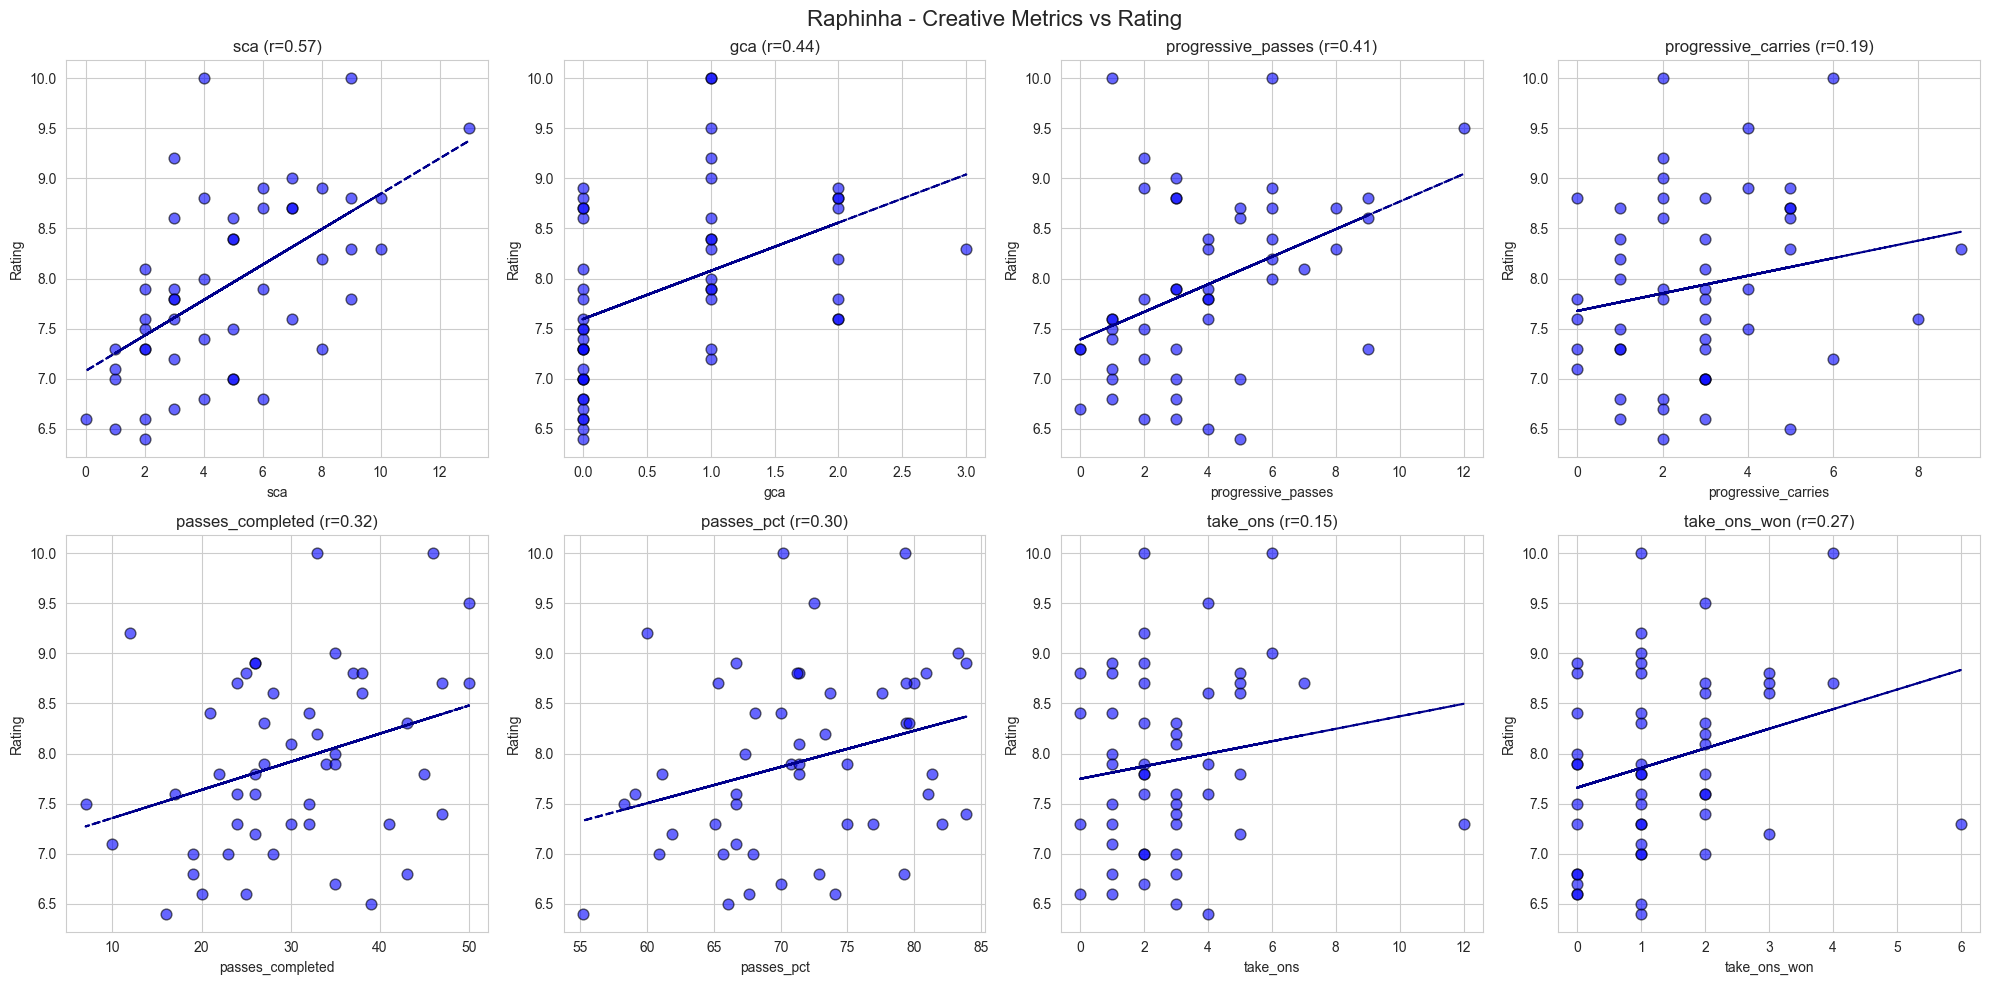

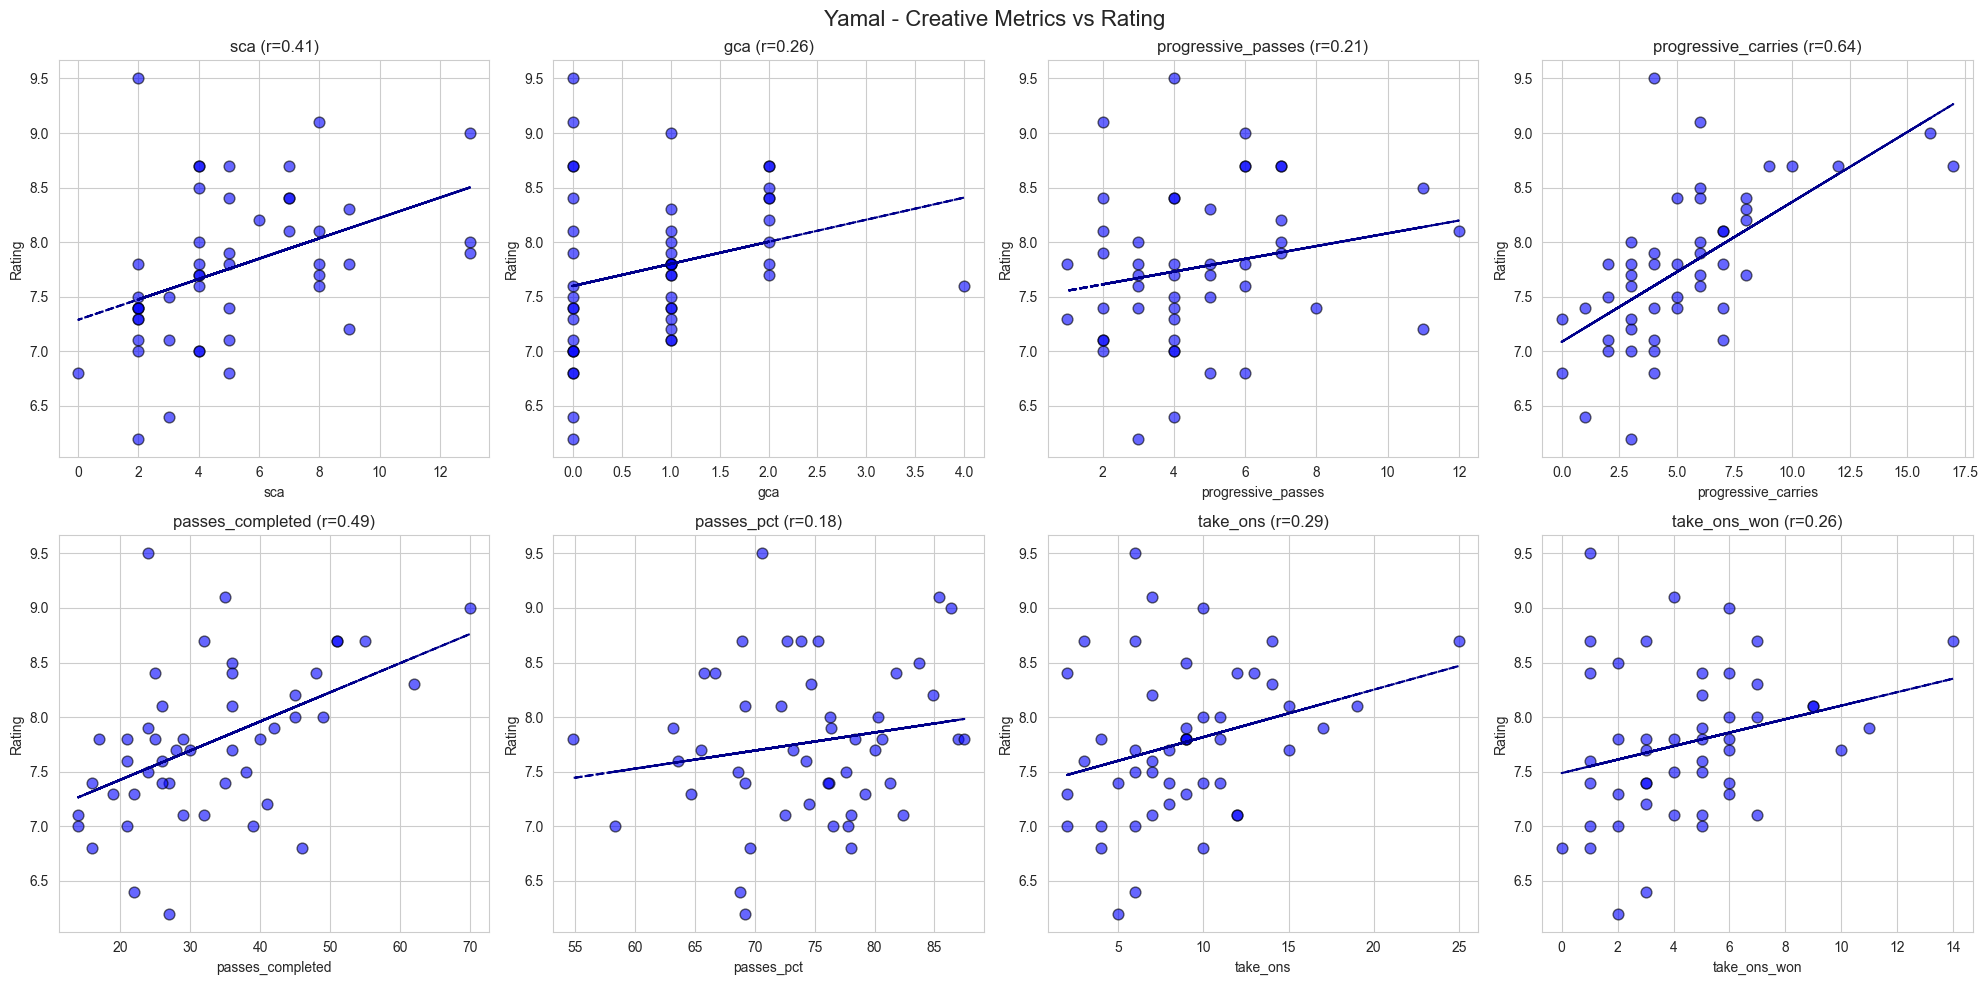

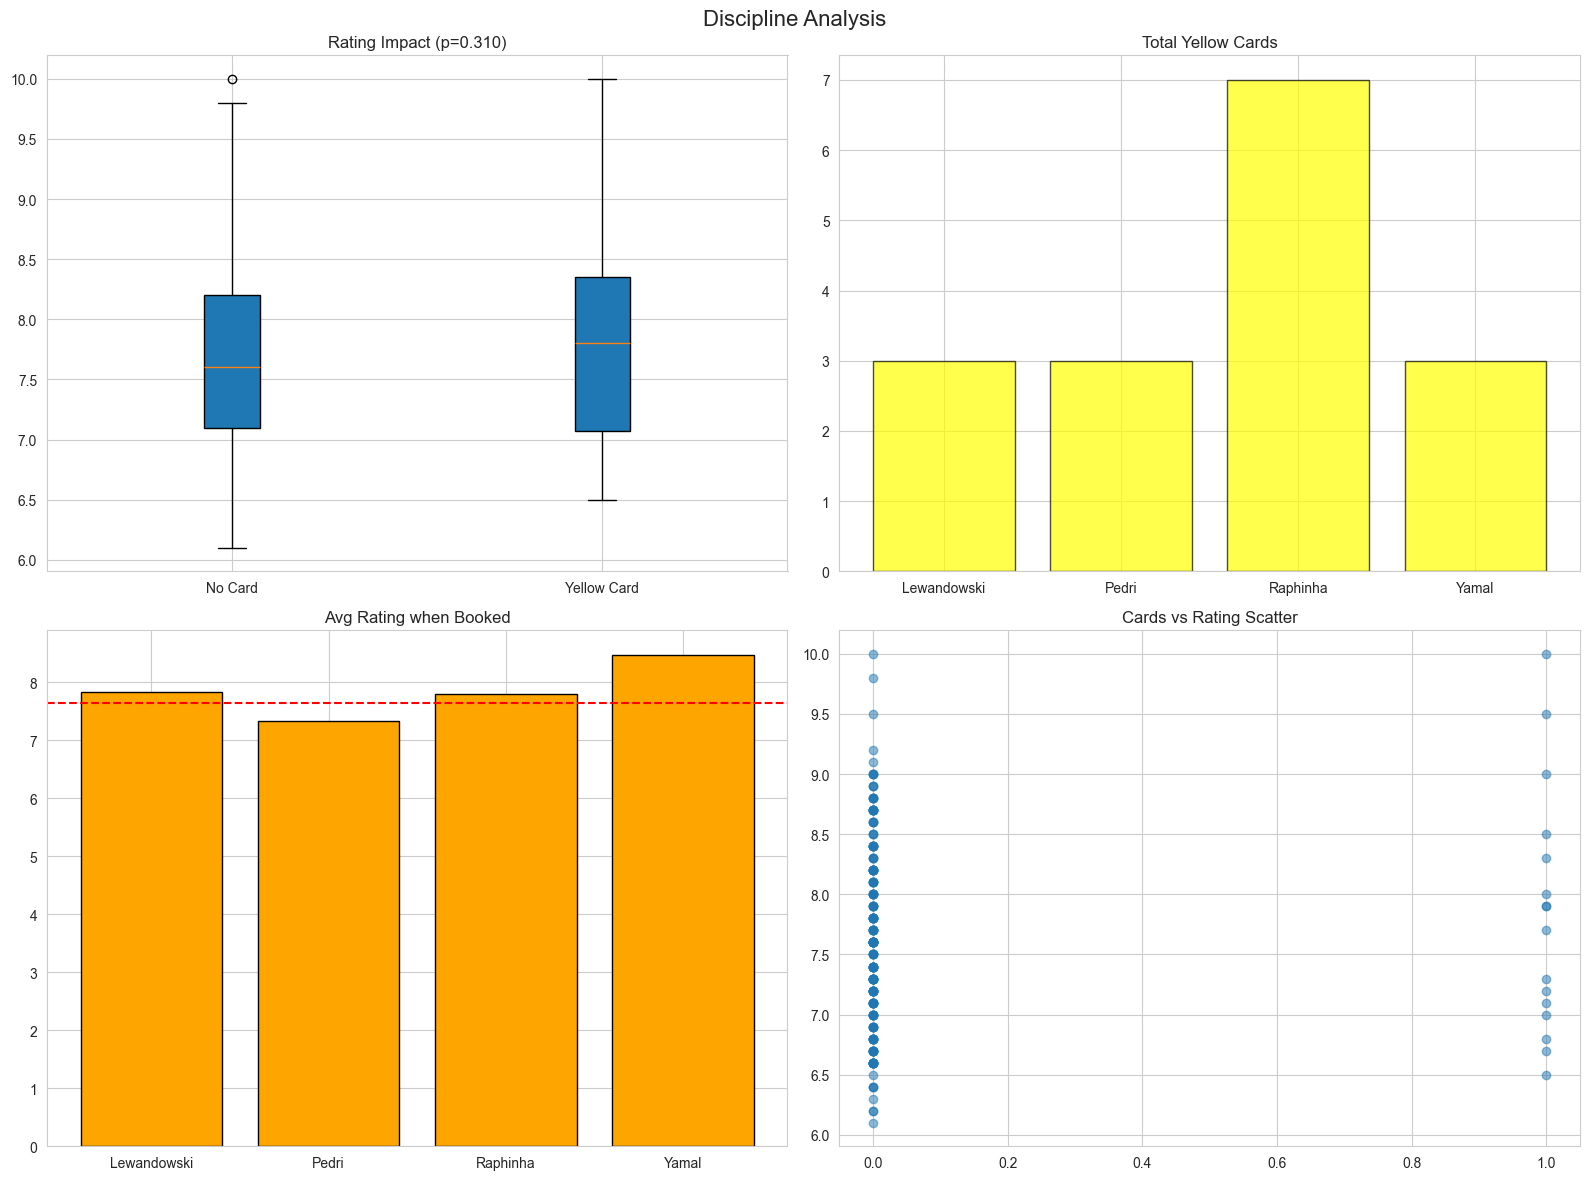

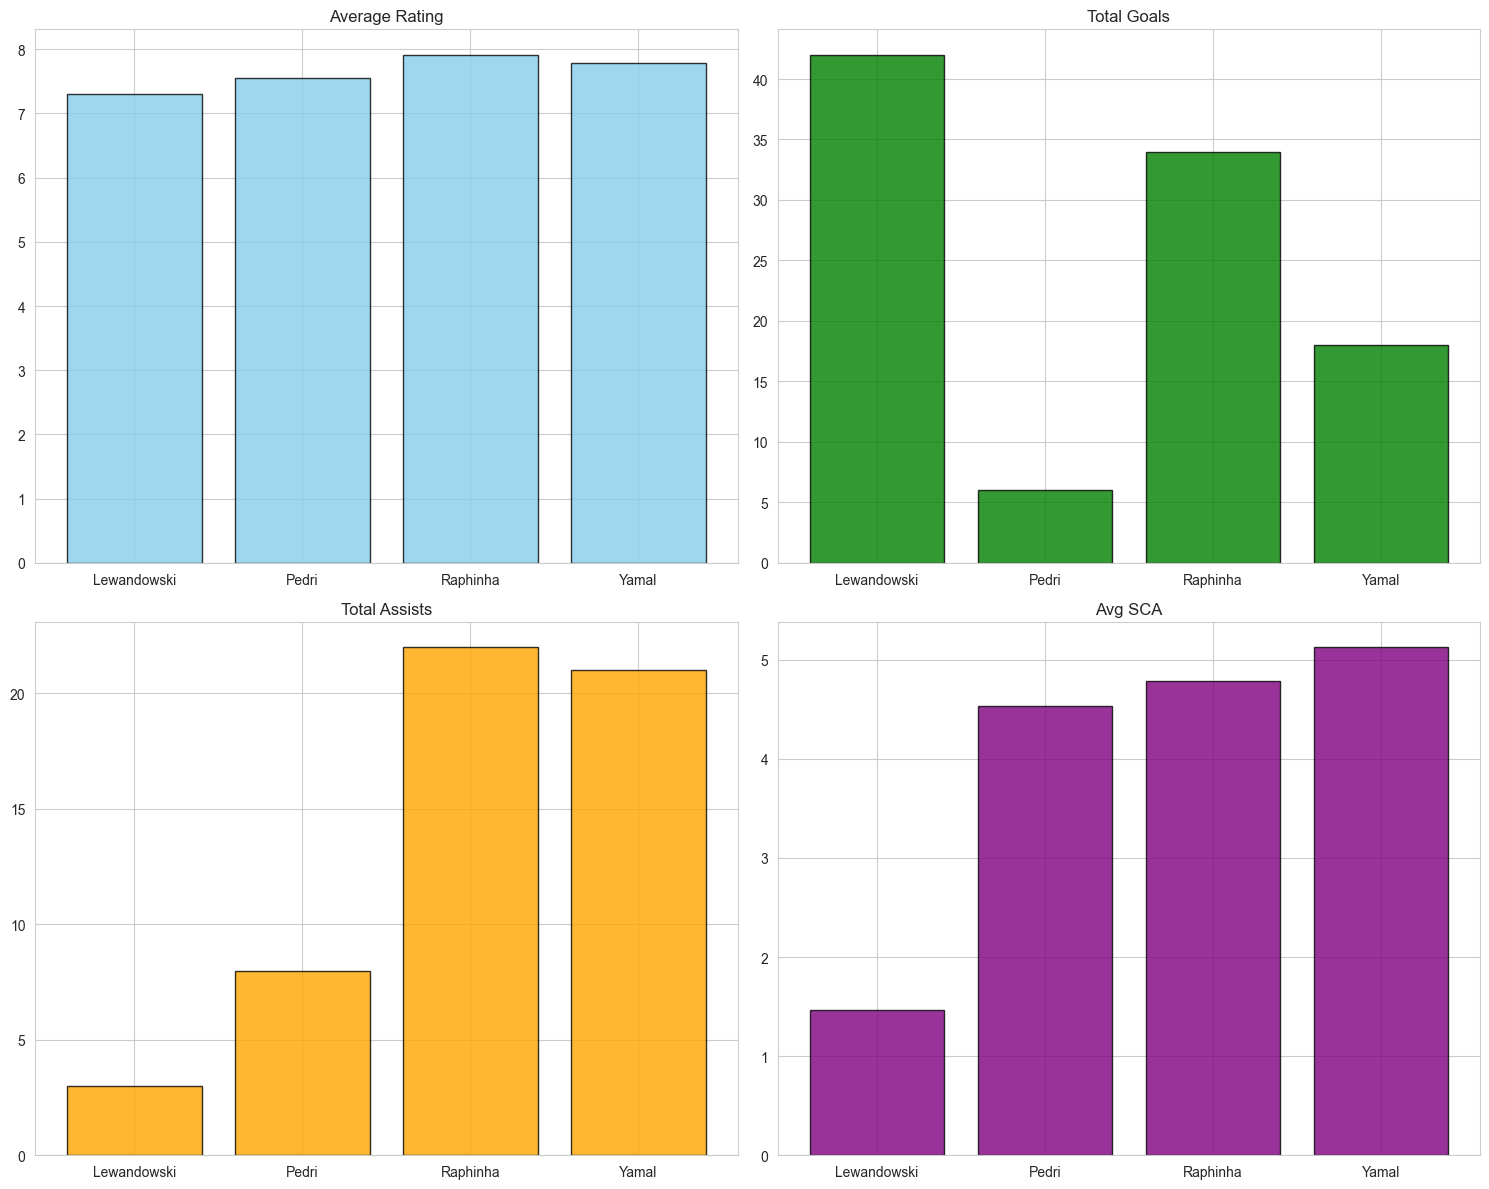

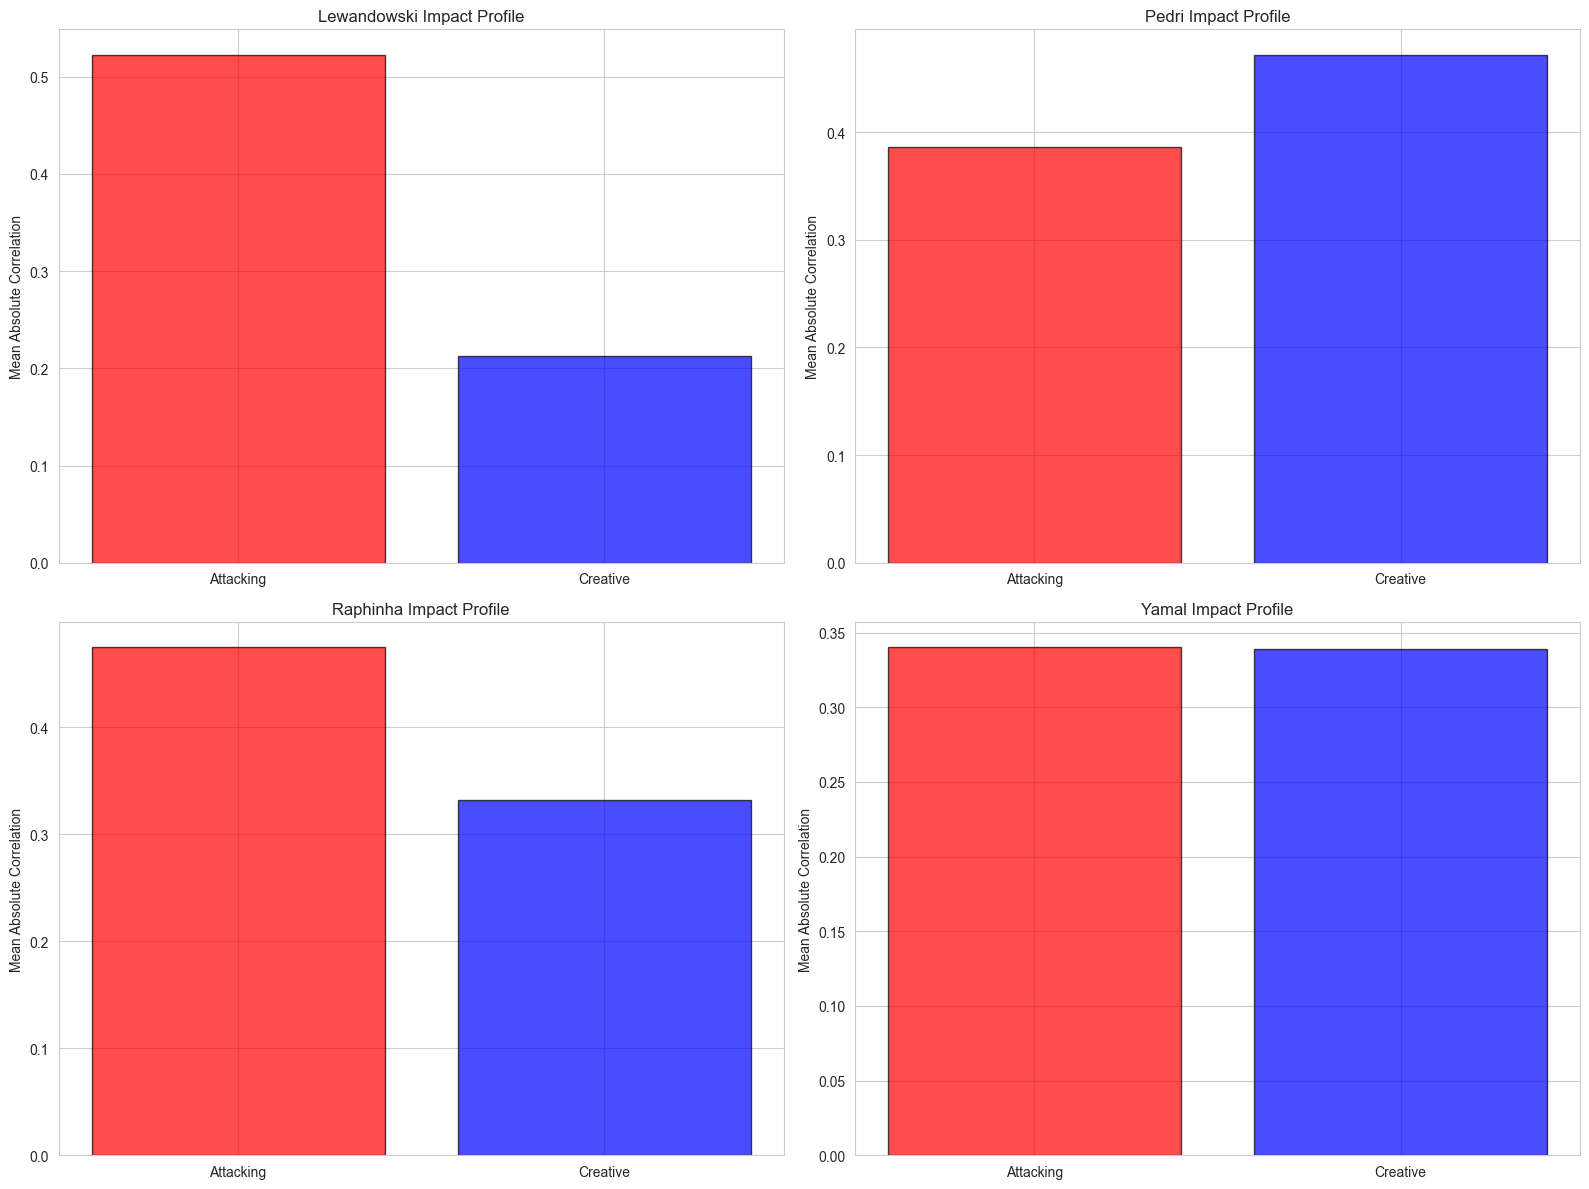

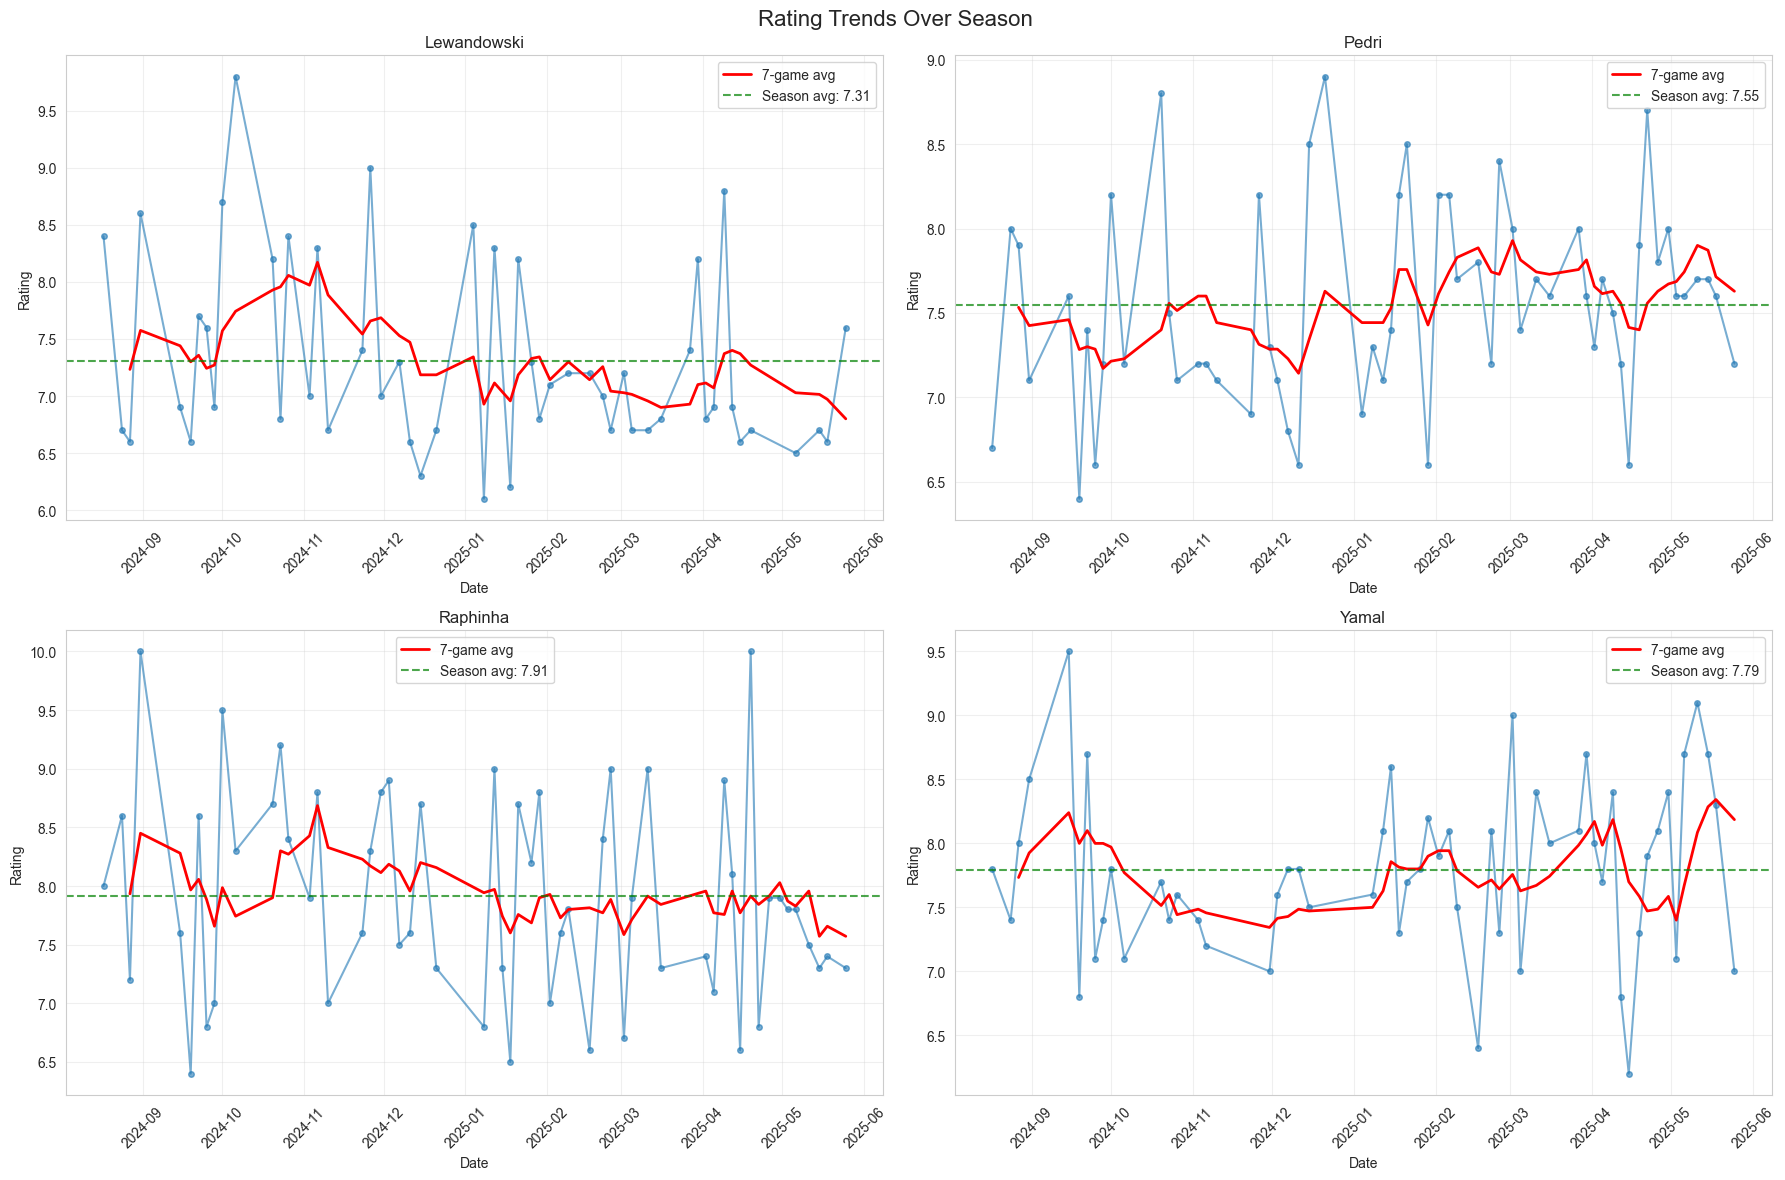

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

class BarcelonaViz:
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        
        # Redefine lists for plotting
        self.attacking_metrics = ['Gls', 'Ast', 'shots', 'shots_on_target', 'xg', 'npxg', 'xg_assist']
        self.creative_metrics = ['sca', 'gca', 'progressive_passes', 'progressive_carries', 
                                'passes_completed', 'passes_pct', 'take_ons', 'take_ons_won']
    
    def run_all_plots(self):
        print("Generating visualizations...")
        self.plot_rating_distributions_kde()
        
        self.plot_correlation_heatmap()
        
        self.plot_violin_by_result()
        
        self.plot_scatter_attacking_per_player()
        


        self.plot_scatter_creative_per_player()
        self.plot_discipline_analysis()
        self.plot_player_comparison()
        self.plot_attacking_vs_creative_impact()
        self.plot_rating_trends_over_season()

    def plot_rating_distributions_kde(self):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Player Rating Distributions (KDE)', fontsize=16)
        
        players = self.df['Player'].unique()
        for idx, player in enumerate(players):
            if idx >= 4: break
            ax = axes[idx // 2, idx % 2]
            player_data = self.df[self.df['Player'] == player]
            
            ax.hist(player_data['Rating'], bins=15, edgecolor='black', alpha=0.5, 
                   color='skyblue', density=True)
            
            from scipy.stats import gaussian_kde
            try:
                kde = gaussian_kde(player_data['Rating'].dropna())
                x_range = np.linspace(player_data['Rating'].min(), player_data['Rating'].max(), 100)
                ax.plot(x_range, kde(x_range), 'r-', linewidth=2)
            except:
                pass 
            
            ax.axvline(player_data['Rating'].mean(), color='darkred', linestyle='--')
            ax.set_title(f'{player} (n={len(player_data)})')
            ax.set_xlabel('Rating')
        
        plt.tight_layout()
        plt.show() # Display inline
    
    def plot_correlation_heatmap(self):
        key_metrics = ['Rating', 'Gls', 'Ast', 'xg', 'xg_assist', 'sca', 'gca',
                      'progressive_passes', 'progressive_carries', 'passes_pct', 'touches']
        available = [m for m in key_metrics if m in self.df.columns]
        
        corr_matrix = self.df[available].corr()
        
        fig, ax = plt.subplots(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                    center=0, square=True, vmin=-1, vmax=1, ax=ax)
        
        ax.set_title('Correlation Heatmap')
        plt.tight_layout()
        plt.show()
    
    def plot_violin_by_result(self):
        metrics = ['Rating', 'Gls', 'Ast', 'xg', 'sca', 'progressive_passes']
        available = [m for m in metrics if m in self.df.columns]
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for idx, metric in enumerate(available):
            ax = axes[idx]
            plot_data = []
            
            for result_type in ['W', 'D', 'L']:
                mask = self.df['result'].str.contains(result_type, na=False) & self.df[metric].notna()
                if mask.sum() > 0:
                    temp_df = pd.DataFrame({'Value': self.df.loc[mask, metric], 'Result': result_type})
                    plot_data.append(temp_df)
            
            if plot_data:
                combined = pd.concat(plot_data, ignore_index=True)
                parts = ax.violinplot([combined[combined['Result'] == r]['Value'].values 
                                     for r in ['W', 'D', 'L'] if r in combined['Result'].unique()],
                                    showmeans=True, showmedians=True)
                
                colors = ['lightgreen', 'lightyellow', 'lightcoral']
                for pc, color in zip(parts['bodies'], colors):
                    pc.set_facecolor(color)
                    pc.set_alpha(0.7)
                
                ax.set_xticks(range(1, len(combined['Result'].unique()) + 1))
                ax.set_xticklabels([r for r in ['W', 'D', 'L'] if r in combined['Result'].unique()])
                ax.set_title(metric)
        
        plt.tight_layout()
        plt.show()
    
    def plot_scatter_attacking_per_player(self):
        self._plot_scatter_grid(self.attacking_metrics, 'attacking', 'red')

    def plot_scatter_creative_per_player(self):
        self._plot_scatter_grid(self.creative_metrics, 'creative', 'blue')
        
    def _plot_scatter_grid(self, metrics, category_name, color):
        available = [m for m in metrics if m in self.df.columns]
        players = self.df['Player'].unique()
        
        for player in players:
            player_data = self.df[self.df['Player'] == player]
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            fig.suptitle(f'{player} - {category_name.title()} Metrics vs Rating', fontsize=16)
            axes = axes.flatten()
            
            for idx, metric in enumerate(available[:8]):
                ax = axes[idx]
                mask = player_data[metric].notna() & player_data['Rating'].notna()
                
                if mask.sum() > 5:
                    x = player_data.loc[mask, metric]
                    y = player_data.loc[mask, 'Rating']
                    
                    ax.scatter(x, y, alpha=0.6, s=60, color=color, edgecolors='black')
                    
                    if len(x) > 2:
                        z = np.polyfit(x, y, 1)
                        p = np.poly1d(z)
                        ax.plot(x, p(x), color=f"dark{color}", linestyle='--')
                    
                    corr_p, _ = stats.pearsonr(x, y)
                    ax.set_xlabel(metric)
                    ax.set_ylabel('Rating')
                    ax.set_title(f'{metric} (r={corr_p:.2f})')
                else:
                    ax.text(0.5, 0.5, 'Insufficient data', ha='center', transform=ax.transAxes)
            
            for idx in range(len(available), 8):
                fig.delaxes(axes[idx])
                
            plt.tight_layout()
            plt.show()

    def plot_discipline_analysis(self):
        if 'cards_yellow' not in self.df.columns: return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Discipline Analysis', fontsize=16)
        
        # 1. Rating Impact
        ax = axes[0, 0]
        mask = self.df['cards_yellow'].notna() & self.df['Rating'].notna()
        with_card = self.df.loc[mask & (self.df['cards_yellow'] > 0), 'Rating']
        without_card = self.df.loc[mask & (self.df['cards_yellow'] == 0), 'Rating']
        
        if len(with_card) > 0 and len(without_card) > 0:
            ax.boxplot([without_card, with_card], labels=['No Card', 'Yellow Card'], patch_artist=True)
            t_stat, p_val = stats.ttest_ind(with_card, without_card)
            ax.set_title(f'Rating Impact (p={p_val:.3f})')
        
        # 2. Total Cards
        ax = axes[0, 1]
        players = self.df['Player'].unique()
        yellow_counts = [self.df[self.df['Player'] == p]['cards_yellow'].sum() for p in players]
        ax.bar(players, yellow_counts, color='yellow', edgecolor='black', alpha=0.7)
        ax.set_title('Total Yellow Cards')
        
        # 3. Rating when Booked
        ax = axes[1, 0]
        ratings_when_booked = []
        labels = []
        for player in players:
            pd_sub = self.df[self.df['Player'] == player]
            mask = (pd_sub['cards_yellow'] > 0) & pd_sub['Rating'].notna()
            if mask.sum() > 0:
                ratings_when_booked.append(pd_sub.loc[mask, 'Rating'].mean())
                labels.append(player)
        
        if ratings_when_booked:
            ax.bar(labels, ratings_when_booked, color='orange', edgecolor='black')
            ax.set_title('Avg Rating when Booked')
            ax.axhline(self.df['Rating'].mean(), color='red', linestyle='--')
            
        # 4. Scatter
        ax = axes[1, 1]
        mask = self.df['cards_yellow'].notna() & self.df['Rating'].notna()
        ax.scatter(self.df.loc[mask, 'cards_yellow'], self.df.loc[mask, 'Rating'], alpha=0.5)
        ax.set_title('Cards vs Rating Scatter')

        plt.tight_layout()
        plt.show()

    def plot_player_comparison(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        players = self.df['Player'].unique()
        
        metrics = [
            ('Rating', 'mean', 'Average Rating', 'skyblue'),
            ('Gls', 'sum', 'Total Goals', 'green'),
            ('Ast', 'sum', 'Total Assists', 'orange'),
            ('sca', 'mean', 'Avg SCA', 'purple')
        ]
        
        for idx, (col, agg, title, color) in enumerate(metrics):
            if col not in self.df.columns: continue
            ax = axes[idx // 2, idx % 2]
            
            if agg == 'mean':
                values = [self.df[self.df['Player'] == p][col].mean() for p in players]
            else:
                values = [self.df[self.df['Player'] == p][col].sum() for p in players]
                
            ax.bar(players, values, color=color, alpha=0.8, edgecolor='black')
            ax.set_title(title)
            
        plt.tight_layout()
        plt.show()

    def plot_attacking_vs_creative_impact(self):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        players = self.df['Player'].unique()
        
        for idx, player in enumerate(players):
            if idx >= 4: break
            ax = axes[idx // 2, idx % 2]
            player_data = self.df[self.df['Player'] == player]
            
            def get_avg_corr(metrics):
                corrs = []
                for m in metrics:
                    if m in player_data.columns:
                        mask = player_data[m].notna() & player_data['Rating'].notna()
                        if mask.sum() > 5:
                            c, _ = stats.pearsonr(player_data.loc[mask, m], player_data.loc[mask, 'Rating'])
                            corrs.append(abs(c))
                return np.mean(corrs) if corrs else 0
            
            avg_att = get_avg_corr(self.attacking_metrics)
            avg_cre = get_avg_corr(self.creative_metrics)
            
            ax.bar(['Attacking', 'Creative'], [avg_att, avg_cre], 
                  color=['red', 'blue'], alpha=0.7, edgecolor='black')
            ax.set_title(f'{player} Impact Profile')
            ax.set_ylabel('Mean Absolute Correlation')
            
        plt.tight_layout()
        plt.show()
        
    def plot_rating_trends_over_season(self):
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle('Rating Trends Over Season', fontsize=16)
        axes = axes.flatten()
        
        players = self.df['Player'].unique()
        
        for idx, player in enumerate(players):
            if idx >= 4: break
            ax = axes[idx]
            player_data = self.df[self.df['Player'] == player].sort_values('Date')
            
            ax.plot(player_data['Date'], player_data['Rating'], 
                   marker='o', linestyle='-', alpha=0.6, markersize=4)
            
            if len(player_data) > 7:
                rolling_avg = player_data['Rating'].rolling(window=7, min_periods=3).mean()
                ax.plot(player_data['Date'], rolling_avg, 
                       color='red', linewidth=2, label='7-game avg')
            
            avg_rating = player_data['Rating'].mean()
            ax.axhline(avg_rating, color='green', linestyle='--', 
                      alpha=0.7, label=f'Season avg: {avg_rating:.2f}')
            
            ax.set_title(f'{player}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Rating')
            ax.legend()
            ax.grid(alpha=0.3)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()

# --- EXECUTION ---
# Pass the dataframe processed in Part 1
viz = BarcelonaViz(stats_eda.get_dataframe())
viz.run_all_plots()

# Hypothesis Testing

## Tests
1. **H1**: Individual metrics (npxg, shots, xA, SCA, progressive passes/carries, take-ons) correlate with player ratings
2. **H2**: Team aggregate metrics (total npxg, SCA, goals, avg rating) differ across W/D/L outcomes

## Methods
- Pearson correlation (H1)
- ANOVA (H2)
- Assumption checks: Shapiro-Wilk (normality), Levene's (variance homogeneity)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, shapiro, levene
import warnings
import os

warnings.filterwarnings('ignore')

class BarcelonaHypothesisStats:
    def __init__(self, data_file):
        if not os.path.exists(data_file):
            raise FileNotFoundError(f"Data file not found: {data_file}")
            
        self.df = pd.read_csv(data_file)
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        
        # Metric Definitions
        self.attacking_metrics = ['npxg', 'shots'] 
        self.creative_metrics = [
            'xg_assist', 
            'sca', 
            'progressive_passes', 
            'take_ons_won',
            'progressive_carries'
        ]
        
        print(f"Initialized analysis. Data shape: {self.df.shape}")
    
    def get_data(self):
        return self.df

    def check_assumptions(self):
        print("\n" + "="*50)
        print(" ASSUMPTION CHECKS ")
        print("="*50)
        
        # 1. Normality Test (Shapiro-Wilk)
        data_rating = self.df['Rating'].dropna()
        if len(data_rating) > 3:
            stat, p = shapiro(data_rating)
            result = "Normal" if p > 0.05 else "Non-normal"
            print(f"Rating Normality: W={stat:.4f}, p={p:.4f} ({result})")

        # 2. Homogeneity of Variance (Levene's Test)
        groups = []
        for r in ['W', 'D', 'L']:
            subset = self.df[self.df['result'].str.contains(r, na=False)]['Rating'].dropna()
            groups.append(subset)
        
        if all(len(g) > 0 for g in groups):
            stat, p = levene(*groups)
            result = "Equal Variances" if p > 0.05 else "Unequal Variances"
            print(f"Variance Homogeneity (W/D/L): W={stat:.4f}, p={p:.4f} ({result})")
    
    def phase1_metrics_to_rating(self):
        print("\n" + "="*50)
        print(" PHASE 1: CORRELATION TESTS ")
        print("="*50)
        
        results = []
        all_metrics = self.attacking_metrics + self.creative_metrics
        
        for player in self.df['Player'].unique():
            player_data = self.df[self.df['Player'] == player]
            print(f"Processing {player}...")
            
            for metric in all_metrics:
                if metric in player_data.columns:
                    mask = player_data[metric].notna() & player_data['Rating'].notna()
                    
                    if mask.sum() > 5:
                        corr, p = stats.pearsonr(player_data.loc[mask, metric], player_data.loc[mask, 'Rating'])
                        
                        results.append({
                            'Player': player,
                            'Metric': metric,
                            'Type': 'Attacking' if metric in self.attacking_metrics else 'Creative',
                            'Correlation': corr,
                            'Significant': p < 0.05
                        })
                        
                        sig_marker = "*" if p < 0.05 else ""
                        print(f"  {metric}: r={corr:.3f} {sig_marker}")
        return pd.DataFrame(results)
    
    def phase2_rating_to_outcome(self):
        print("\n" + "="*50)
        print(" PHASE 2: ANOVA TESTS ")
        print("="*50)
        
        match_agg = self.create_match_aggregates()
        metrics = ['Total_npxG', 'Total_SCA', 'Total_Goals', 'Avg_Rating', 'Total_PrgCarries']
        
        anova_results = []
        for metric in metrics:
            if metric in match_agg.columns:
                groups = [match_agg[match_agg['result'].str.contains(r, na=False)][metric].dropna() for r in ['W', 'D', 'L']]
                
                if all(len(g) > 0 for g in groups):
                    f, p = f_oneway(*groups)
                    sig = "*" if p < 0.05 else ""
                    print(f"{metric}: F={f:.3f}, p={p:.4f} {sig}")
                    anova_results.append({'Metric': metric, 'Significant': p < 0.05})
        
        return match_agg, anova_results

    def create_match_aggregates(self):
        agg_rules = {
            'npxg': 'sum', 
            'sca': 'sum', 
            'Gls': 'sum', 
            'Rating': 'mean', 
            'progressive_carries': 'sum', 
            'result': 'first'
        }
        agg_rules = {k: v for k, v in agg_rules.items() if k in self.df.columns}
        
        match_agg = self.df.groupby(['Date', 'Opponent']).agg(agg_rules).reset_index()
        
        rename_map = {
            'npxg': 'Total_npxG', 
            'sca': 'Total_SCA', 
            'Gls': 'Total_Goals', 
            'Rating': 'Avg_Rating', 
            'progressive_carries': 'Total_PrgCarries'
        }
        return match_agg.rename(columns=rename_map)

# --- EXECUTION ---
data_file = 'fbref_sofascore_merged_by_date_only.csv'
stats_ht = BarcelonaHypothesisStats(data_file)
stats_ht.check_assumptions()
corr_results = stats_ht.phase1_metrics_to_rating()
match_agg, anova_results = stats_ht.phase2_rating_to_outcome()

Initialized analysis. Data shape: (223, 39)

 ASSUMPTION CHECKS 
Rating Normality: W=0.9759, p=0.0007 (Non-normal)
Variance Homogeneity (W/D/L): W=0.0389, p=0.9618 (Equal Variances)

 PHASE 1: CORRELATION TESTS 
Processing Lewandowski...
  npxg: r=0.543 *
  shots: r=0.422 *
  xg_assist: r=0.329 *
  sca: r=0.263 
  progressive_passes: r=0.060 
  take_ons_won: r=0.243 
  progressive_carries: r=0.309 *
Processing Pedri...
  npxg: r=0.341 *
  shots: r=0.328 *
  xg_assist: r=0.718 *
  sca: r=0.651 *
  progressive_passes: r=0.760 *
  take_ons_won: r=0.518 *
  progressive_carries: r=0.256 
Processing Raphinha...
  npxg: r=0.418 *
  shots: r=0.354 *
  xg_assist: r=0.515 *
  sca: r=0.575 *
  progressive_passes: r=0.414 *
  take_ons_won: r=0.273 
  progressive_carries: r=0.195 
Processing Yamal...
  npxg: r=0.233 
  shots: r=0.363 *
  xg_assist: r=0.486 *
  sca: r=0.410 *
  progressive_passes: r=0.206 
  take_ons_won: r=0.257 
  progressive_carries: r=0.636 *

 PHASE 2: ANOVA TESTS 
Total_npxG: 

## Outputs
2 plots: metric-rating correlations per player, team metrics by result

Generating visualizations...


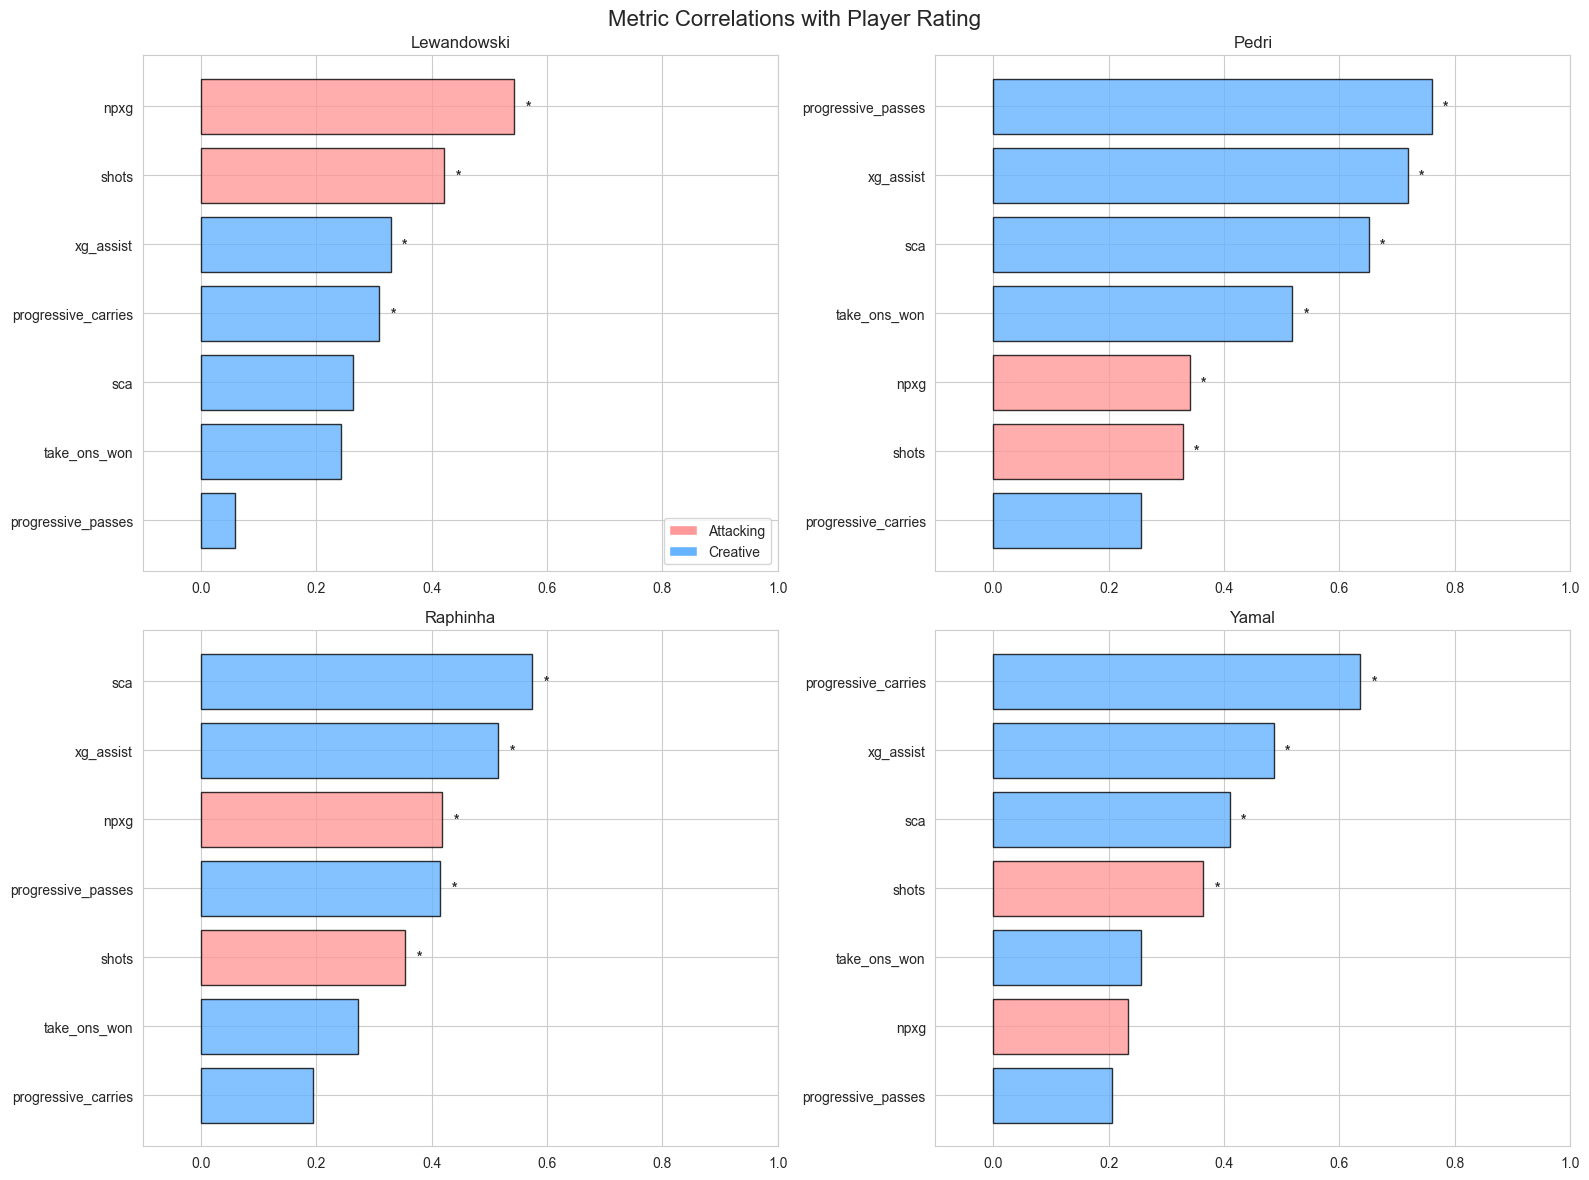

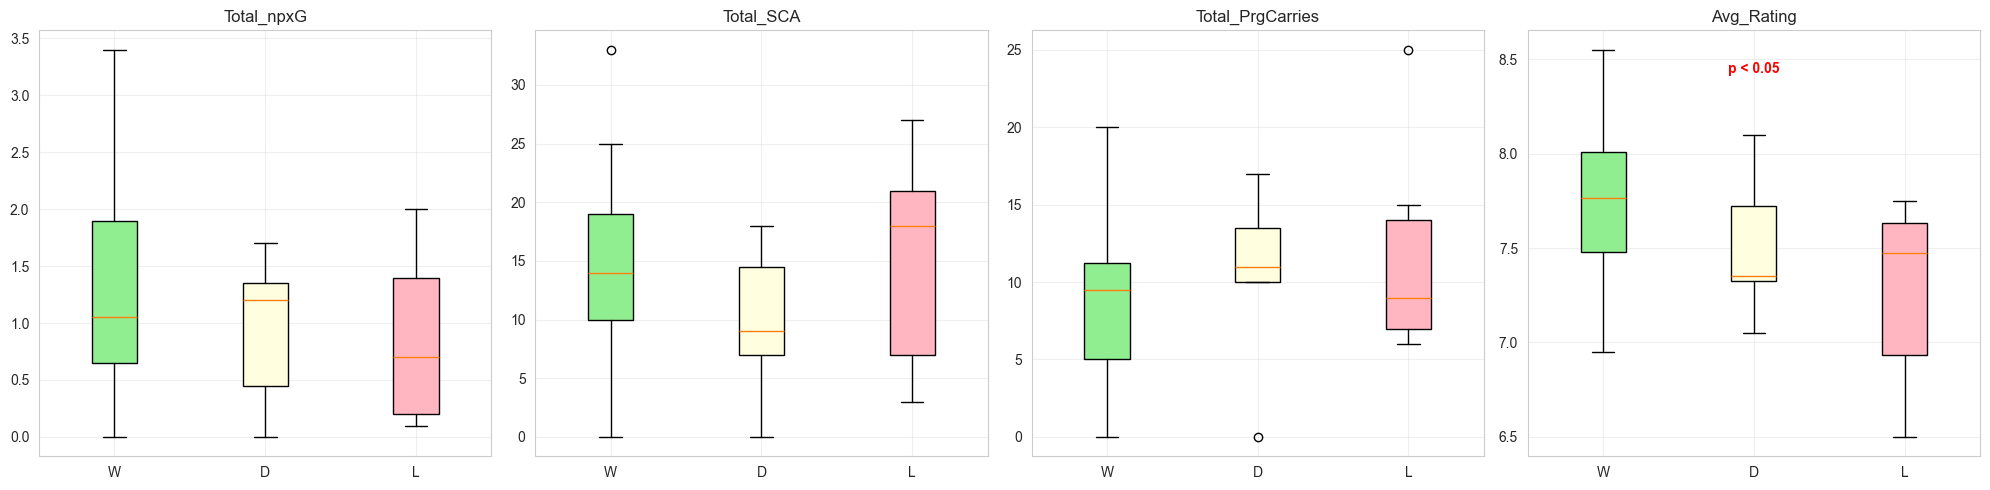

In [13]:
# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

class BarcelonaHypothesisViz:
    def __init__(self):
        pass
    
    def run_all_plots(self, corr_results, match_agg, anova_results):
        print("Generating visualizations...")
        self.plot_phase1_results(corr_results)
        


        self.plot_phase2_results(match_agg, anova_results)
        



    def plot_phase1_results(self, df_results):
        if df_results.empty: return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Metric Correlations with Player Rating', fontsize=16)
        
        players = df_results['Player'].unique()
        for idx, player in enumerate(players):
            if idx >= 4: break
            ax = axes[idx // 2, idx % 2]
            p_data = df_results[df_results['Player'] == player].sort_values('Correlation')
            
            colors = ['#ff9999' if t == 'Attacking' else '#66b3ff' for t in p_data['Type']]
            bars = ax.barh(p_data['Metric'], p_data['Correlation'], color=colors, edgecolor='black', alpha=0.8)
            
            # Mark significance
            for bar, sig in zip(bars, p_data['Significant']):
                if sig:
                    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
                            '*', va='center', fontweight='bold')

            ax.set_title(player)
            ax.set_xlim(-0.1, 1.0)
            
            if idx == 0:
                from matplotlib.patches import Patch
                legend_elements = [Patch(facecolor='#ff9999', label='Attacking'),
                                 Patch(facecolor='#66b3ff', label='Creative')]
                ax.legend(handles=legend_elements, loc='lower right')

        plt.tight_layout()
        plt.show() # Display inline

    def plot_phase2_results(self, match_agg, anova_results):
        metrics_to_plot = ['Total_npxG', 'Total_SCA', 'Total_PrgCarries', 'Avg_Rating']
        available_metrics = [m for m in metrics_to_plot if m in match_agg.columns]
        
        fig, axes = plt.subplots(1, len(available_metrics), figsize=(20, 5)) 
        
        for idx, metric in enumerate(available_metrics):
            ax = axes[idx] if len(available_metrics) > 1 else axes
            
            data_to_plot = []
            labels = ['W', 'D', 'L']
            colors = ['#90EE90', '#FFFFE0', '#FFB6C1']
            
            for r in labels:
                subset = match_agg[match_agg['result'].str.contains(r, na=False)][metric].dropna()
                data_to_plot.append(subset.values)
            
            bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
            
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
            
            ax.set_title(metric)
            ax.grid(alpha=0.3)
            
            # Annotate significance
            is_sig = next((r['Significant'] for r in anova_results if r['Metric'] == metric), False)
            if is_sig:
                ax.text(0.5, 0.9, 'p < 0.05', transform=ax.transAxes, ha='center', 
                        color='red', fontweight='bold')

        plt.tight_layout()
        plt.show()

# --- EXECUTION ---
# Pass the results processed in Part 1
viz_ht = BarcelonaHypothesisViz()
viz_ht.run_all_plots(corr_results, match_agg, anova_results)

# Barcelona ML Analysis

## Goal
Predict player ratings (regression) and match outcomes (classification) using performance metrics.

## Approach
- **Regression**: Includes goals/assists to predict ratings
- **Classification**: Excludes goals/assists to predict W/D/L from performance stats
- **Two splits**: Temporal (80/20 chronological) and Random (80/20 shuffled)

## Models
Ridge, Lasso, Random Forest, XGBoost with GridSearchCV hyperparameter tuning

## SMOTE Variants
Tests SMOTE, BorderlineSMOTE, SVMSMOTE to handle class imbalance (W=73%, D=12%, L=15%)

## Outputs
- Regression: R² scores, feature importance (top 15)
- Classification: Accuracy, confusion matrix, classification report, feature importance
- 12 visualizations saved to `results/`

## Key Finding
Regression achieves R²~0.76 (random split). Classification struggles vs baseline due to severe class imbalance and lack of goals in feature set.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

os.makedirs('results', exist_ok=True)


def load_and_prep_data(filepath):
    """Load data and create basic features"""
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Create simple features
    if 'passes_completed' in df.columns and 'touches' in df.columns:
        df['pass_efficiency'] = df['passes_completed'] / (df['touches'] + 1)
    
    if 'progressive_passes' in df.columns and 'progressive_carries' in df.columns:
        df['progressive_actions'] = df['progressive_passes'] + df['progressive_carries']
    
    if 'tackles' in df.columns and 'interceptions' in df.columns:
        df['defensive_work'] = df['tackles'] + df['interceptions']
    
    if 'result' in df.columns:
        df['result_type'] = df['result'].str.extract(r'([WDL])', expand=False)
    
    return df


def get_features_regression(df):
    """Get features for regression - keeps Gls/Ast"""
    exclude = ['Date', 'Player', 'Team', 'Opponent', 'result', 'result_type',
               'Rating', 'Started', 'Position', 'venue', 'Competition', 'Venue']
    
    features = [col for col in df.columns 
                if col not in exclude and df[col].dtype in ['int64', 'float64']]
    return features


def get_features_classification(df):
    """Get features for classification - excludes Gls/Ast"""
    exclude = ['Date', 'Player', 'Team', 'Opponent', 'result', 'result_type',
               'Rating', 'Started', 'Position', 'venue', 'Competition', 'Venue',
               'Gls', 'Ast', 'Goal_Contribution']
    
    features = [col for col in df.columns 
                if col not in exclude and df[col].dtype in ['int64', 'float64']]
    return features


def run_regression(df, split_type='random'):
    """Run regression to predict Rating"""
    print(f"\n{'='*60}")
    print(f"REGRESSION - Rating Prediction ({split_type.upper()} SPLIT)")
    print(f"{'='*60}")
    
    # Get data
    features = get_features_regression(df)
    X = df[features].fillna(0)
    y = df['Rating'].fillna(df['Rating'].median())
    
    # Split data
    if split_type == 'temporal':
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"Train: {len(X_train)}, Test: {len(X_test)}")
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Test models with full hyperparameter grids
    results = {}
    models = {}
    
    # Ridge - full grid
    ridge = GridSearchCV(Ridge(), {'alpha': [0.1, 1.0, 10.0, 100.0]}, cv=5)
    ridge.fit(X_train_scaled, y_train)
    y_pred = ridge.predict(X_test_scaled)
    results['Ridge'] = r2_score(y_test, y_pred)
    models['Ridge'] = ridge.best_estimator_
    
    # Lasso - full grid
    lasso = GridSearchCV(Lasso(max_iter=10000), {'alpha': [0.01, 0.1, 1.0, 10.0]}, cv=5)
    lasso.fit(X_train_scaled, y_train)
    y_pred = lasso.predict(X_test_scaled)
    results['Lasso'] = r2_score(y_test, y_pred)
    models['Lasso'] = lasso.best_estimator_
    
    # Random Forest - full grid
    rf = GridSearchCV(RandomForestRegressor(random_state=42), 
                      {'n_estimators': [50, 100, 150], 
                       'max_depth': [5, 10, 15],
                       'min_samples_leaf': [3, 5, 8]}, cv=5)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    results['Random Forest'] = r2_score(y_test, y_pred)
    models['Random Forest'] = rf.best_estimator_
    
    # XGBoost - full grid
    xgb_model = GridSearchCV(xgb.XGBRegressor(random_state=42),
                             {'n_estimators': [50, 100, 150],
                              'max_depth': [3, 5, 7],
                              'learning_rate': [0.01, 0.1, 0.3]}, cv=5)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    results['XGBoost'] = r2_score(y_test, y_pred)
    models['XGBoost'] = xgb_model.best_estimator_
    
    # Print results
    print("\nResults:")
    for model, r2 in results.items():
        print(f"  {model:20s} R² = {r2:.4f}")
    
    best = max(results, key=results.get)
    print(f"\nBest: {best} (R² = {results[best]:.4f})")
    
    # Plot model comparison
    plt.figure(figsize=(10, 6))
    plt.barh(list(results.keys()), list(results.values()), color='teal', edgecolor='black')
    plt.xlabel('R² Score')
    plt.title(f'Model Comparison - {split_type.upper()} Split')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'results/regression_comparison_{split_type}.png', dpi=150)
    plt.close()
    
    # Plot feature importance for best model
    best_model = models[best]
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        importances = np.abs(best_model.coef_)  # Use absolute value for magnitude        
    if importances is not None:
        indices = np.argsort(importances)[::-1][:15]
        plt.figure(figsize=(10, 8))
        plt.barh(range(15), importances[indices], color='green', edgecolor='black')
        plt.yticks(range(15), [features[i] for i in indices])
        plt.xlabel('Importance')
        plt.title(f'Top 15 Features - {best} ({split_type.upper()})')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f'results/regression_features_{split_type}.png', dpi=150)
        plt.close()
    
    return results


def run_classification(df, split_type='random'):
    """Run classification to predict Win/Draw/Loss"""
    print(f"\n{'='*60}")
    print(f"CLASSIFICATION - Outcome Prediction ({split_type.upper()} SPLIT)")
    print(f"{'='*60}")
    
    # Get data
    df_clean = df.dropna(subset=['result_type'])
    features = get_features_classification(df_clean)
    X = df_clean[features].fillna(0)
    
    # Encode target
    le = LabelEncoder()
    y = le.fit_transform(df_clean['result_type'])
    
    # Split
    if split_type == 'temporal':
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"Train: {len(X_train)}, Test: {len(X_test)}")
    print(f"Baseline (predict W): {np.sum(y_test == 2) / len(y_test):.2%}")
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    smote_variants = {
        'SMOTE': SMOTE(random_state=42, sampling_strategy='not majority'),
        'BorderlineSMOTE': BorderlineSMOTE(random_state=42, sampling_strategy='not majority'),
        'SVMSMOTE': SVMSMOTE(random_state=42, sampling_strategy='not majority'),
    }
    
    best_smote = None
    best_acc = 0
    best_X_train = None
    best_y_train = None
    
    print("\nTesting SMOTE variants:")
    for smote_name, smote in smote_variants.items():
        try:
            X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
            
            # Quick test
            test_rf = RandomForestClassifier(n_estimators=100, random_state=42)
            test_rf.fit(X_resampled, y_resampled)
            y_pred = test_rf.predict(X_test_scaled)
            acc = accuracy_score(y_test, y_pred)
            print(f"  {smote_name:20s} Accuracy = {acc:.2%}")
            
            if acc > best_acc:
                best_acc = acc
                best_smote = smote_name
                best_X_train = X_resampled
                best_y_train = y_resampled
        except Exception as e:
            print(f"  {smote_name:20s} Failed: {str(e)[:50]}")
    
    print(f"\nBest SMOTE: {best_smote} ({best_acc:.2%})")
    
    # Test models with full hyperparameter grids
    results = {}
    models = {}
    
    # Random Forest - full grid
    rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'),
                      {'n_estimators': [100, 150, 200],
                       'max_depth': [10, 14, 18],
                       'min_samples_leaf': [5, 8, 10]}, cv=5)
    rf.fit(best_X_train, best_y_train)
    y_pred = rf.predict(X_test_scaled)
    results['Random Forest'] = accuracy_score(y_test, y_pred)
    models['Random Forest'] = (rf.best_estimator_, y_pred)
    
    # XGBoost - full grid
    xgb_model = GridSearchCV(xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),
                             {'n_estimators': [100, 150],
                              'max_depth': [5, 7, 10],
                              'learning_rate': [0.01, 0.1]}, cv=5)
    xgb_model.fit(best_X_train, best_y_train)
    y_pred = xgb_model.predict(X_test_scaled)
    results['XGBoost'] = accuracy_score(y_test, y_pred)
    models['XGBoost'] = (xgb_model.best_estimator_, y_pred)
    
    # Print results
    print("\nResults:")
    for model, acc in results.items():
        print(f"  {model:20s} Accuracy = {acc:.2%}")
    
    best = max(results, key=results.get)
    print(f"\nBest: {best} ({results[best]:.2%})")
    
    # Classification report
    best_model, y_pred = models[best]
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {best} ({split_type.upper()})')
    plt.tight_layout()
    plt.savefig(f'results/classification_confusion_{split_type}.png', dpi=150)
    plt.close()
    
    # Plot feature importance
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]
        
        plt.figure(figsize=(10, 8))
        plt.barh(range(15), importances[indices], color='purple', edgecolor='black')
        plt.yticks(range(15), [features[i] for i in indices])
        plt.xlabel('Importance')
        plt.title(f'Top 15 Features - {best} ({split_type.upper()})')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f'results/classification_features_{split_type}.png', dpi=150)
        plt.close()
    
    # Plot model comparison
    plt.figure(figsize=(10, 6))
    plt.barh(list(results.keys()), list(results.values()), color='orange', edgecolor='black')
    plt.xlabel('Accuracy')
    plt.title(f'Model Comparison - {split_type.upper()} Split')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'results/classification_comparison_{split_type}.png', dpi=150)
    plt.close()
    
    return results


def main():
    print("\n" + "="*60)
    print("SIMPLE BARCELONA ML ANALYSIS")
    print("="*60)
    
    # Load data
    df = load_and_prep_data('fbref_sofascore_merged_by_date_only.csv')
    print(f"\nLoaded {len(df)} matches")
    print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
    
    # Run both split types
    for split_type in ['temporal', 'random']:
        print(f"\n\n{'#'*60}")
        print(f"TESTING {split_type.upper()} SPLIT")
        print(f"{'#'*60}")
        
        # Regression
        reg_results = run_regression(df, split_type)
        
        # Classification
        clf_results = run_classification(df, split_type)
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)


if __name__ == "__main__":
    main()


SIMPLE BARCELONA ML ANALYSIS

Loaded 223 matches
Date range: 2024-08-17 to 2025-05-25


############################################################
TESTING TEMPORAL SPLIT
############################################################

REGRESSION - Rating Prediction (TEMPORAL SPLIT)
Train: 178, Test: 45

Results:
  Ridge                R² = 0.4676
  Lasso                R² = 0.6518
  Random Forest        R² = 0.4398
  XGBoost              R² = 0.4993

Best: Lasso (R² = 0.6518)

CLASSIFICATION - Outcome Prediction (TEMPORAL SPLIT)
Train: 178, Test: 45
Baseline (predict W): 75.56%

Testing SMOTE variants:
  SMOTE                Accuracy = 68.89%
  BorderlineSMOTE      Accuracy = 73.33%
  SVMSMOTE             Accuracy = 68.89%

Best SMOTE: BorderlineSMOTE (73.33%)

Results:
  Random Forest        Accuracy = 68.89%
  XGBoost              Accuracy = 66.67%

Best: Random Forest (68.89%)

Classification Report:
              precision    recall  f1-score   support

           D       0.00     

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>